## Installations

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyranges as pr
import seaborn as sns
import xarray as xr

# Seaborn customisation
sns.set_theme()
sns.set_style("whitegrid")
biomodal_palette = ["#003B49", "#9CDBD9", "#F87C56", "#C0DF16", "#05868E"]
sns.set_palette(biomodal_palette)

from modality.datasets import load_biomodal_dataset
from modality.annotation import (
    get_genes,
    get_transcription_end_region,
    get_tss_region,
    get_exons,
    get_introns,
    get_five_prime_utrs,
    get_three_prime_utrs,
    get_transcripts,
    get_cpg_islands,
)

Load ES-E14 evoC dataset

In [2]:
from modality.contig_dataset import ContigDataset
def unify_chr_names(ds: ContigDataset) -> ContigDataset:
    # Extract the contig column
    selected_column = ds["contig"].values
    
    # Check if the contigs start with "chr" and remove it if they do
    unified_contigs = np.array([contig[3:] if contig.startswith("chr") else contig 
                                for contig in selected_column],dtype='U20')
    
    # Assign the unified contigs back to the dataset
    ds = ds.assign_coords(contig=("pos", unified_contigs))

    ds.attrs["contigs"] = [contig.replace("chr", "") for contig in ds.attrs["contigs"]]

    
    # Print unique values of the contig column
    print(np.unique(ds["contig"].values))
    return ds


def unify_slice_names(ds):
    # Iterate through the dataset attributes and update slice names
    for key in list(ds.attrs.keys()):
        if key.startswith('slice_chr'):
            new_key = key.replace('slice_chr', 'slice_')
            ds.attrs[new_key] = ds.attrs.pop(key)
    
    return ds

def load_data(dataset="", contexts=["num_modc"]):
    #downloads modality.contig_dataset.ContigDataset object
    if dataset != "":  
        ds = ContigDataset.from_zarrz(dataset)
        ds = unify_chr_names(ds)
        ds = unify_slice_names(ds)
    else:
        ds = load_biomodal_dataset()
        # ds = ContigDataset.from_zarrz("../ES-E14.zarrz")
        ds = ds.drop_vars(["Input DNA Quantity (ng/sample)", "tech_replicate_number"])  
    ds = ds.sum(dim="sample_id", keep_attrs=True)
    ds = ds.expand_dims(dim="sample_id", axis=1)
    ds = ds.assign_coords(sample_id=["sample_0"])
    ds.assign_fractions(
        numerators=contexts,
        denominator="num_total_c",
        min_coverage=10,
        inplace=True,
    )
    return ds

In [5]:
# ds = load_data("../data/CEGX_Run1485_CG.zarrz", ["num_modc", "num_mc", "num_hmc"])
# ds = load_data("../data/CEGX_Run1485_CG.zarrz", ["num_modc"])
## ds.to_zarrz("../data/CEGX_Run1485_CG_renamed.zarrz")
ds = load_data("../data/e14_GRCm38p6_CG.zarrz",["num_modc"])

['1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '3' '4' '5' '6'
 '7' '8' '9' 'M' 'X' 'Y']


2024-10-02 11:13:13 | WARNING | [modality/contig_dataset.py:340] "sample_id" coordinate is missing but expected to be set by many ContigDataset methods.
It can be added using the `assign_coords` method, e.g. `ds.assign_coords(sample_id = ("sample_id", ["sample1", "sample2"]))`
2024-10-02 11:13:17 | WARNING | [modality/contig_dataset.py:340] "sample_id" coordinate is missing but expected to be set by many ContigDataset methods.
It can be added using the `assign_coords` method, e.g. `ds.assign_coords(sample_id = ("sample_id", ["sample1", "sample2"]))`


In [6]:
ds

ContigDataset(data_vars=Data variables:
    end           (pos, sample_id) uint64 dask.array<chunksize=(100000, 1), meta=np.ndarray>
    num_c         (pos, sample_id) uint64 dask.array<chunksize=(100000, 1), meta=np.ndarray>
    num_modc      (pos, sample_id) uint64 dask.array<chunksize=(100000, 1), meta=np.ndarray>
    num_other     (pos, sample_id) uint64 dask.array<chunksize=(100000, 1), meta=np.ndarray>
    num_total     (pos, sample_id) uint64 dask.array<chunksize=(100000, 1), meta=np.ndarray>
    num_total_c   (pos, sample_id) uint64 dask.array<chunksize=(100000, 1), meta=np.ndarray>
    percent_modc  (pos, sample_id) uint64 dask.array<chunksize=(100000, 1), meta=np.ndarray>
    frac_modc     (pos, sample_id) float64 dask.array<chunksize=(100000, 1), meta=np.ndarray>, coords=Coordinates:
    contig        (pos) <U20 '1' '1' '1' '1' '1' '1' ... 'M' 'M' 'M' 'M' 'M' 'M'
    ref_position  (pos) int64 dask.array<chunksize=(100000,), meta=np.ndarray>
    strand        (pos) <U2 dask.array<chunksize=(100000,), meta=np.ndarray>
  * sample_id     (sample_id) <U8 'sample_0'
    group         (sample_id) <U8 'sample_0', attrs={'context': 'CG', 'context_sampling': 1.0, 'contigs': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', 'X', 'Y', 'M'], 'coordinate_basis': 0, 'fasta_path': 'GRCm38p6.fa.block.gz', 'input_path': ['SRR610039.genome.GRCm38p6_primary_assembly.dedup_CpG.bedGraph.gz', 'SRR610040.genome.GRCm38p6_primary_assembly.dedup_CpG.bedGraph.gz'], 'quant_type': 'bedgraph', 'ref_name': 'GRCm38p6', 'sample_ids': ['SRR610039', 'SRR610040'], 'slice_1': slice(0, 2955122, 1), 'slice_10': slice(22942856, 25156266, 1), 'slice_11': slice(25156266, 27483352, 1), 'slice_12': slice(27483352, 29396382, 1), 'slice_13': slice(29396382, 31363950, 1), 'slice_14': slice(31363950, 33246688, 1), 'slice_15': slice(33246688, 34988556, 1), 'slice_16': slice(34988556, 36499138, 1), 'slice_17': slice(36499138, 38208052, 1), 'slice_18': slice(38208052, 39651134, 1), 'slice_19': slice(39651134, 40767246, 1), 'slice_2': slice(2955122, 5997996, 1), 'slice_3': slice(5997996, 8380428, 1), 'slice_4': slice(8380428, 11046376, 1), 'slice_5': slice(11046376, 13751626, 1), 'slice_6': slice(13751626, 16083622, 1), 'slice_7': slice(16083622, 18533500, 1), 'slice_8': slice(18533500, 20801442, 1), 'slice_9': slice(20801442, 22942856, 1), 'slice_M': slice(43735100, 43735674, 1), 'slice_X': slice(40767246, 42706184, 1), 'slice_Y': slice(42706184, 43735100, 1), 'frac_denominator': 'num_total_c', 'frac_min_coverage': 10})

#### subset `ContigDataset` by strand

In [7]:
# modified set_contig_slices()
import dask.array as da
def set_contig_slices(xds: xr.Dataset) -> xr.Dataset:
    """
    Given a dataset with a contig data array, compute the slices for each contig and
    store them in the dataset attributes.

    Args:
        xds: xarray dataset to be processed

    Returns:
        input dataset with the contig slices set in the attributes
    """
    print("Computing available chromosomes.")

    # Ensure contig is a Dask array
    contig_data = da.from_array(xds.contig.data) if not isinstance(xds.contig.data, da.Array) else xds.contig.data

    # Compute unique labels and the first index
    contig_labels, contig_first_index = da.compute(*da.unique(contig_data, return_index=True))


    # contig_labels, contig_first_index = da.compute(
    #     *da.unique(xds.contig.data, return_index=True)
    # )

    # TODO sort by reference order.
    contig_labels = contig_labels[np.argsort(contig_first_index)]
    contig_first_index = contig_first_index[np.argsort(contig_first_index)]

    # TODO mouse
    """
    assert all(
        contig_labels == valid_contigs
    ), f"{contig_labels} do not match expectation ({valid_contigs})"
    """

    last_index = len(xds.contig.data)

    print(
        f'Found available contigs: {",".join([x.replace("chr","") for x in contig_labels])}.'
    )

    xds.attrs["contigs"] = [str(xx) for xx in contig_labels]

    # for var in ["contig", "icontig"]:
    #    if var in xds.variables:
    #        xds = xds.drop([var])

    if len(contig_labels) == 1:
        xds.attrs[f"slice_{contig_labels[0]}"] = (0, last_index, 1)
        return xds

    # work out slices if multiple contigs
    contig_first_index = dict(zip(contig_labels, contig_first_index))

    for icontig, (contig, contig_next) in enumerate(
        zip(contig_labels[:-1], contig_labels[1:])
    ):
        xds.attrs[f"slice_{contig}"] = (
            contig_first_index[contig],
            contig_first_index[contig_next],
            1,
        )
    else:
        xds.attrs[f"slice_{contig_next}"] = (
            contig_first_index[contig_next],
            last_index,
            1,
        )

    return xds

In [8]:
from modality.contig_dataset import cast_result

def refresh_slices(subset_data):
    if subset_data.pos.size == 0:
            raise ValueError(
                "Subset is empty. Please check the coverage values and method used."
            )
    else:
        slices = [x for x in subset_data.attrs if x.startswith("slice")]
        for sl in slices:
            subset_data.attrs.pop(sl)
        return set_contig_slices(subset_data)

def split_strand(data, strand):
    """
    split xarray dataset into positive and negative strands
    Parameters
        data : xarray.Dataset
        strand : str ('+', '-')
    Returns
        strand_data :xarray.Dataset
    """
    strand_mask = (data['strand'].data == strand).compute()
    masked_da = xr.DataArray(strand_mask, dims=data['strand'].dims, coords=data['strand'].coords)
    strand_data = data.where(masked_da, drop=True)

    # return strand_data
    return cast_result(refresh_slices(strand_data.ds))

def remove_low_coverage(data: xr, threshold: int) -> xr.Dataset:
    """
    Removes data points with num_total_c less than the given threshold.

    Parameters:
    - data (xr.Dataset): The input dataset containing the variable `num_total_c`.
    - threshold (int): The threshold value. Rows with `num_total_c` less than this will be removed.

    Returns:
    - xr.Dataset: The dataset with rows filtered by the threshold.
    """
    # Ensure that num_total_c exists and has valid dimensions
    if 'num_total_c' not in data.data_vars:
        raise ValueError("The dataset does not contain the 'num_total_c' variable.")
    
    coverage_mask = (data['num_total_c'].data >= threshold).compute()
    masked_da = xr.DataArray(coverage_mask, dims=data['num_total_c'].dims, coords=data['num_total_c'].coords)
    # Apply the mask to the dataset and drop positions that don't meet the threshold
    filtered_data = data.where(masked_da, drop=True)
    
    return cast_result(refresh_slices(filtered_data.ds))

In [9]:
# ds.attrs["contigs"] = [contig.replace("chr", "") for contig in strand_data.attrs["contigs"]]
# strand_mask = (ds['strand'].data == '+').compute()
# masked_da = xr.DataArray(strand_mask, dims=ds['strand'].dims, coords=ds['strand'].coords)
# strand_data = ds.where(masked_da, drop=True)

In [13]:
ds

ContigDataset(data_vars=Data variables:
    end           (pos, sample_id) uint64 dask.array<chunksize=(100000, 1), meta=np.ndarray>
    num_c         (pos, sample_id) uint64 dask.array<chunksize=(100000, 1), meta=np.ndarray>
    num_modc      (pos, sample_id) uint64 dask.array<chunksize=(100000, 1), meta=np.ndarray>
    num_other     (pos, sample_id) uint64 dask.array<chunksize=(100000, 1), meta=np.ndarray>
    num_total     (pos, sample_id) uint64 dask.array<chunksize=(100000, 1), meta=np.ndarray>
    num_total_c   (pos, sample_id) uint64 dask.array<chunksize=(100000, 1), meta=np.ndarray>
    percent_modc  (pos, sample_id) uint64 dask.array<chunksize=(100000, 1), meta=np.ndarray>
    frac_modc     (pos, sample_id) float64 dask.array<chunksize=(100000, 1), meta=np.ndarray>, coords=Coordinates:
    contig        (pos) <U20 '1' '1' '1' '1' '1' '1' ... 'M' 'M' 'M' 'M' 'M' 'M'
    ref_position  (pos) int64 dask.array<chunksize=(100000,), meta=np.ndarray>
    strand        (pos) <U2 dask.array<chunksize=(100000,), meta=np.ndarray>
  * sample_id     (sample_id) <U8 'sample_0'
    group         (sample_id) <U8 'sample_0', attrs={'context': 'CG', 'context_sampling': 1.0, 'contigs': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', 'X', 'Y', 'M'], 'coordinate_basis': 0, 'fasta_path': 'GRCm38p6.fa.block.gz', 'input_path': ['SRR610039.genome.GRCm38p6_primary_assembly.dedup_CpG.bedGraph.gz', 'SRR610040.genome.GRCm38p6_primary_assembly.dedup_CpG.bedGraph.gz'], 'quant_type': 'bedgraph', 'ref_name': 'GRCm38p6', 'sample_ids': ['SRR610039', 'SRR610040'], 'slice_1': slice(0, 2955122, 1), 'slice_10': slice(22942856, 25156266, 1), 'slice_11': slice(25156266, 27483352, 1), 'slice_12': slice(27483352, 29396382, 1), 'slice_13': slice(29396382, 31363950, 1), 'slice_14': slice(31363950, 33246688, 1), 'slice_15': slice(33246688, 34988556, 1), 'slice_16': slice(34988556, 36499138, 1), 'slice_17': slice(36499138, 38208052, 1), 'slice_18': slice(38208052, 39651134, 1), 'slice_19': slice(39651134, 40767246, 1), 'slice_2': slice(2955122, 5997996, 1), 'slice_3': slice(5997996, 8380428, 1), 'slice_4': slice(8380428, 11046376, 1), 'slice_5': slice(11046376, 13751626, 1), 'slice_6': slice(13751626, 16083622, 1), 'slice_7': slice(16083622, 18533500, 1), 'slice_8': slice(18533500, 20801442, 1), 'slice_9': slice(20801442, 22942856, 1), 'slice_M': slice(43735100, 43735674, 1), 'slice_X': slice(40767246, 42706184, 1), 'slice_Y': slice(42706184, 43735100, 1), 'frac_denominator': 'num_total_c', 'frac_min_coverage': 10})

In [11]:
plus_strand

ContigDataset(data_vars=Data variables:
    end           (pos, sample_id) float64 dask.array<chunksize=(99853, 1), meta=np.ndarray>
    num_c         (pos, sample_id) float64 dask.array<chunksize=(99853, 1), meta=np.ndarray>
    num_modc      (pos, sample_id) float64 dask.array<chunksize=(99853, 1), meta=np.ndarray>
    num_other     (pos, sample_id) float64 dask.array<chunksize=(99853, 1), meta=np.ndarray>
    num_total     (pos, sample_id) float64 dask.array<chunksize=(99853, 1), meta=np.ndarray>
    num_total_c   (pos, sample_id) float64 dask.array<chunksize=(99853, 1), meta=np.ndarray>
    percent_modc  (pos, sample_id) float64 dask.array<chunksize=(99853, 1), meta=np.ndarray>
    frac_modc     (pos, sample_id) float64 dask.array<chunksize=(99853, 1), meta=np.ndarray>, coords=Coordinates:
    contig        (pos) <U20 '1' '1' '1' '1' '1' '1' ... 'M' 'M' 'M' 'M' 'M' 'M'
    ref_position  (pos) int64 dask.array<chunksize=(99853,), meta=np.ndarray>
    strand        (pos) <U2 dask.array<chunksize=(99853,), meta=np.ndarray>
  * sample_id     (sample_id) <U8 'sample_0'
    group         (sample_id) <U8 'sample_0', attrs={'context': 'CG', 'context_sampling': 1.0, 'contigs': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', 'X', 'Y', 'M'], 'coordinate_basis': 0, 'fasta_path': 'GRCm38p6.fa.block.gz', 'frac_denominator': 'num_total_c', 'frac_min_coverage': 10, 'input_path': ['SRR610039.genome.GRCm38p6_primary_assembly.dedup_CpG.bedGraph.gz', 'SRR610040.genome.GRCm38p6_primary_assembly.dedup_CpG.bedGraph.gz'], 'quant_type': 'bedgraph', 'ref_name': 'GRCm38p6', 'sample_ids': ['SRR610039', 'SRR610040'], 'slice_1': slice(0, 1477561, 1), 'slice_10': slice(11471428, 12578133, 1), 'slice_11': slice(12578133, 13741676, 1), 'slice_12': slice(13741676, 14698191, 1), 'slice_13': slice(14698191, 15681975, 1), 'slice_14': slice(15681975, 16623344, 1), 'slice_15': slice(16623344, 17494278, 1), 'slice_16': slice(17494278, 18249569, 1), 'slice_17': slice(18249569, 19104026, 1), 'slice_18': slice(19104026, 19825567, 1), 'slice_19': slice(19825567, 20383623, 1), 'slice_2': slice(1477561, 2998998, 1), 'slice_3': slice(2998998, 4190214, 1), 'slice_4': slice(4190214, 5523188, 1), 'slice_5': slice(5523188, 6875813, 1), 'slice_6': slice(6875813, 8041811, 1), 'slice_7': slice(8041811, 9266750, 1), 'slice_8': slice(9266750, 10400721, 1), 'slice_9': slice(10400721, 11471428, 1), 'slice_M': slice(21867550, 21867837, 1), 'slice_X': slice(20383623, 21353092, 1), 'slice_Y': slice(21353092, 21867550, 1)})

In [12]:
plus_strand = split_strand(ds, "+")
minus_strand = split_strand( ds, "-")

plus_strand.to_zarrz("../data/plus_strand_wgbs.zarrz")
minus_strand.to_zarrz("../data/minus_strand_wgbs.zarrz")

# get original dataset for comparison
# ds_orig = load_data()
# plus_strand_orig = split_strand(ds_orig, "+")
# minus_strand_orig = split_strand(ds_orig, "-")

2024-10-02 12:54:51 | INFO | [modality/contig_dataset.py:860] Writing to zipped zarr store (ZipStore) ../data/plus_strand_wgbs.zarrz


2024-10-02 12:55:13 | INFO | [modality/contig_dataset.py:860] Writing to zipped zarr store (ZipStore) ../data/minus_strand_wgbs.zarrz


In [5]:
# plus_strand = ContigDataset.from_zarrz("../data/plus_strand.zarrz")
# minus_strand= ContigDataset.from_zarrz("../data/minus_strand.zarrz")
# plus_strand = ContigDataset.from_zarrz("../data/plus_strand.zarrz")
# minus_strand= ContigDataset.from_zarrz("../data/minus_strand.zarrz")

### removing low coverage positions 

In [8]:
# # Compute the dask array into a numpy array
# num_total_c_computed = ds['num_total_c'].compute()

# # Plot the distribution using seaborn or matplotlib
# sns.histplot(num_total_c_computed, bins=50, kde=True)
# plt.title("Distribution of num_total_c, full dataset")
# plt.xlabel("num_total_c values")
# plt.ylabel("Frequency")
# plt.show()

working with strand aware subsets

In [21]:
plus_all = plus_strand["num_total_c"].size
plus_strand_cov = remove_low_coverage(plus_strand, 1)
plus_filtered = plus_strand_cov["num_total_c"].size

print(f"Proportion of instances where num_total_c == 0 in plus_strand: {(plus_all - plus_filtered)/plus_all}")

Computing available chromosomes.
Found available contigs: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,X,Y,M.
Proportion of instances where num_total_c == 0 in plus_strand: 0.28340068567366766


In [22]:
minus_all = minus_strand["num_total_c"].size
minus_strand_cov = remove_low_coverage(minus_strand, 1)
minus_filtered = minus_strand_cov["num_total_c"].size

print(f"Proportion of instances where num_total_c == 0 in minus_strand: {(minus_all - minus_filtered)/minus_all}")

Computing available chromosomes.
Found available contigs: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,X,Y,M.
Proportion of instances where num_total_c == 0 in minus_strand: 0.2835986476394533


In [23]:
# # Compute the dask array into a numpy array
# num_total_c_computed = plus_strand_cov['num_total_c'].compute()

# # Plot the distribution using seaborn or matplotlib
# sns.histplot(num_total_c_computed, bins=50, kde=True)
# plt.title("Distribution of num_total_c, cleaned Plus")
# plt.xlabel("num_total_c values")
# plt.ylabel("Frequency")
# plt.show()

double-checking the counts of remaining positions per contig

In [24]:
for contig in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,'X','Y','M']:
    slice1 = plus_strand_cov.slices[f"slice_{contig}"]
    print(f"slice_{contig}")
    print(plus_strand_cov.ref_position[slice1].data.shape)

slice_1
(1077678,)
slice_2
(1161761,)
slice_3
(862323,)
slice_4
(967887,)
slice_5
(1024250,)
slice_6
(860348,)
slice_7
(876196,)
slice_8
(854983,)
slice_9
(826724,)
slice_10
(833703,)
slice_11
(919831,)
slice_12
(693233,)
slice_13
(730026,)
slice_14
(653738,)
slice_15
(648649,)
slice_16
(555033,)
slice_17
(637832,)
slice_18
(536656,)
slice_19
(425906,)
slice_X
(490083,)
slice_Y
(33457,)
slice_M
(180,)


#### Loading mm10 (GRCm38) reference genome from [GENCODE](https://www.gencodegenes.org/)

In [25]:
# Get the gene annotations
gene_filter = {
    "gene_type": "protein_coding",
    "source": "HAVANA",
}

genes = get_genes(
    reference="mm10",
    as_pyranges=True,
    filterby=gene_filter,
)
print(genes.head(5))

# Get transcripts for mm10
transcripts = get_transcripts(
        reference="mm10",
        contig=None,
        start=None,
        end=None,
        as_pyranges=False,
    )

print('-'*100)

print(f" all genes: {len(genes)}")
print(f" unique gene id: {len(genes.df['Id'])}")


2024-10-02 13:10:36 | INFO | [modality/annotation.py:418] Removing readthrough_gene transcripts for gff (https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M25/gencode.vM25.basic.annotation.gff3.gz)


+--------------+------------+------------+-----------+-----------+-------+
|   Chromosome | Source     | Type       |     Start |       End | +12   |
|   (category) | (object)   | (object)   |   (int64) |   (int64) | ...   |
|--------------+------------+------------+-----------+-----------+-------|
|            1 | HAVANA     | gene       |   4807787 |   4848409 | ...   |
|            1 | HAVANA     | gene       |   4807891 |   4886769 | ...   |
|            1 | HAVANA     | gene       |   4857813 |   4897908 | ...   |
|            1 | HAVANA     | gene       |   5070017 |   5162528 | ...   |
|            1 | HAVANA     | gene       |   5588465 |   5606130 | ...   |
+--------------+------------+------------+-----------+-----------+-------+
Stranded PyRanges object has 5 rows and 17 columns from 1 chromosomes.
For printing, the PyRanges was sorted on Chromosome and Strand.
12 hidden columns: Score, Strand, Phase, Id, Gene_id, Gene_type, Gene_name, Level, ... (+ 4 more.)


2024-10-02 13:10:49 | INFO | [modality/annotation.py:418] Removing readthrough_gene transcripts for gff (https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M25/gencode.vM25.basic.annotation.gff3.gz)


----------------------------------------------------------------------------------------------------
 all genes: 21673
 unique gene id: 21673


#### Select primiary transcript for each gene

In [26]:
def select_transcript_based_on_tag(df):
    # for each transcript in df, select the one with the highest priority tag
    # priorities are:
        # 1. 'basic,appris_principal_1,CCDS'
        # 2. 'basic,appris_principal_1'
        # 3. 'basic,CCDS'
        # 4. 'basic'
    # but with 'exp_conf' (experimentally confirmed) tag, the priority is higher.
    
    priorties = {
        'basic,appris_principal_1,exp_conf,CCDS': 1,
        'basic,appris_principal_1,CCDS': 1,
        'basic,appris_principal_1,exp_conf': 3,
        'basic,appris_principal_1': 4,
        'basic,exp_conf,CCDS': 5,
        'basic,CCDS': 6,
        'basic,exp_conf': 7,
        'basic': 8
    }

    # sort the dataframe by the priority of the tags
    df['tag_priority'] = df.tag.map(priorties)

    df = df.sort_values(by='tag_priority')

    # drop duplicates, keeping the first one
    df = df.drop_duplicates(subset='gene_id', keep='first')

    return df[["gene_id", "transcript_id"]]

selected_transcripts = transcripts.groupby('gene_id').apply(
    select_transcript_based_on_tag
    ).reset_index(drop=True)
selected_transcripts.head()

,gene_id,transcript_id
0,ENSMUSG00000000001.4,ENSMUST00000000001.4
1,ENSMUSG00000000003.15,ENSMUST00000000003.13
2,ENSMUSG00000000028.15,ENSMUST00000000028.13
3,ENSMUSG00000000037.17,ENSMUST00000101113.8
4,ENSMUSG00000000049.11,ENSMUST00000000049.5


In [27]:
# Create dictionary for gene_id to transcript_id mapping
gene_to_transcription = selected_transcripts.set_index('gene_id')['transcript_id'].to_dict()
print(f"There are {len(gene_to_transcription)} genes with unique transcript ids")

There are 21541 genes with unique transcript ids


review / drop genes with no transcripts

In [28]:
# Function to map transcription_id
def map_transcription_id(gene_id, gene_to_transcription):
    return gene_to_transcription.get(gene_id, None)

# Map transcription_id 
genes_df = genes.df
genes_df['Transcript_id'] = genes_df['Gene_id'].map(lambda gene_id: map_transcription_id(gene_id, gene_to_transcription))
genes_clean = pr.PyRanges(genes_df)

# Find and Handle missing gene_ids
missing_gene_ids = genes_clean.df[genes_clean.df['Transcript_id'].isna()]['Gene_id'].tolist()
missing_df = genes_clean.df[genes_clean.df['Gene_id'].isin(missing_gene_ids)]
genes_clean = genes_clean[~genes_clean.df['Transcript_id'].isna()]
print(f"all genes: {len(genes)}")
print(f"all genes with annotated transcripts: {len(genes_clean)}")
genes_clean

all genes: 21673
all genes with annotated transcripts: 21541


,Chromosome,Source,Type,Start,End,Score,Strand,Phase,Id,Gene_id,Gene_type,Gene_name,Level,Mgi_id,Havana_gene,Tag,Ranges_ID,Transcript_id
0,1,HAVANA,gene,4807787,4848409,.,+,.,ENSMUSG00000025903.14,ENSMUSG00000025903.14,protein_coding,Lypla1,2,MGI:1344588,OTTMUSG00000021562.4,overlapping_locus,0,ENSMUST00000027036.10
1,1,HAVANA,gene,4807891,4886769,.,+,.,ENSMUSG00000104217.1,ENSMUSG00000104217.1,protein_coding,Gm37988,2,MGI:5611216,OTTMUSG00000050100.1,overlapping_locus,1,ENSMUST00000155020.1
2,1,HAVANA,gene,4857813,4897908,.,+,.,ENSMUSG00000033813.15,ENSMUSG00000033813.15,protein_coding,Tcea1,2,MGI:1196624,OTTMUSG00000042348.1,overlapping_locus,2,ENSMUST00000081551.13
3,1,HAVANA,gene,5070017,5162528,.,+,.,ENSMUSG00000033793.12,ENSMUSG00000033793.12,protein_coding,Atp6v1h,2,MGI:1914864,OTTMUSG00000050145.9,,3,ENSMUST00000192847.5
4,1,HAVANA,gene,5588465,5606130,.,+,.,ENSMUSG00000025905.14,ENSMUSG00000025905.14,protein_coding,Oprk1,2,MGI:97439,OTTMUSG00000034734.3,,4,ENSMUST00000160777.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21536,Y,HAVANA,gene,78835720,78838055,.,-,.,ENSMUSG00000094739.2,ENSMUSG00000094739.2,protein_coding,Gm20806,2,MGI:5434162,OTTMUSG00000046577.2,,21668,ENSMUST00000190349.1
21537,Y,HAVANA,gene,79148788,79151121,.,-,.,ENSMUSG00000095867.2,ENSMUSG00000095867.2,protein_coding,Gm20917,2,MGI:5434273,OTTMUSG00000046619.2,,21669,ENSMUST00000188706.1
21538,Y,HAVANA,gene,84562571,84564906,.,-,.,ENSMUSG00000094660.2,ENSMUSG00000094660.2,protein_coding,Gm21394,2,MGI:5434749,OTTMUSG00000045415.1,,21670,ENSMUST00000189463.1
21539,Y,HAVANA,gene,85528516,85530907,.,-,.,ENSMUSG00000095650.2,ENSMUSG00000095650.2,protein_coding,Gm20854,2,MGI:5434210,OTTMUSG00000042966.1,,21671,ENSMUST00000181549.1


In [29]:
genes_clean.Strand.value_counts()

Strand
-    10801
+    10740
.        0
Name: count, dtype: int64

In [30]:
genes_plus = genes_clean[genes_clean.Strand == '+']
genes_minus = genes_clean[genes_clean.Strand == '-']
genes_plus

,Chromosome,Source,Type,Start,End,Score,Strand,Phase,Id,Gene_id,Gene_type,Gene_name,Level,Mgi_id,Havana_gene,Tag,Ranges_ID,Transcript_id
0,1,HAVANA,gene,4807787,4848409,.,+,.,ENSMUSG00000025903.14,ENSMUSG00000025903.14,protein_coding,Lypla1,2,MGI:1344588,OTTMUSG00000021562.4,overlapping_locus,0,ENSMUST00000027036.10
1,1,HAVANA,gene,4807891,4886769,.,+,.,ENSMUSG00000104217.1,ENSMUSG00000104217.1,protein_coding,Gm37988,2,MGI:5611216,OTTMUSG00000050100.1,overlapping_locus,1,ENSMUST00000155020.1
2,1,HAVANA,gene,4857813,4897908,.,+,.,ENSMUSG00000033813.15,ENSMUSG00000033813.15,protein_coding,Tcea1,2,MGI:1196624,OTTMUSG00000042348.1,overlapping_locus,2,ENSMUST00000081551.13
3,1,HAVANA,gene,5070017,5162528,.,+,.,ENSMUSG00000033793.12,ENSMUSG00000033793.12,protein_coding,Atp6v1h,2,MGI:1914864,OTTMUSG00000050145.9,,3,ENSMUST00000192847.5
4,1,HAVANA,gene,5588465,5606130,.,+,.,ENSMUSG00000025905.14,ENSMUSG00000025905.14,protein_coding,Oprk1,2,MGI:97439,OTTMUSG00000034734.3,,4,ENSMUST00000160777.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10735,Y,HAVANA,gene,87116820,87142916,.,+,.,ENSMUSG00000094399.7,ENSMUSG00000094399.7,protein_coding,Gm21477,2,MGI:5434832,OTTMUSG00000047083.1,,21601,ENSMUST00000189543.6
10736,Y,HAVANA,gene,87550965,87575690,.,+,.,ENSMUSG00000099856.1,ENSMUSG00000099856.1,protein_coding,Gm20906,2,MGI:5434262,OTTMUSG00000047138.1,,21602,ENSMUST00000186493.1
10737,Y,HAVANA,gene,88053314,88079493,.,+,.,ENSMUSG00000101915.1,ENSMUSG00000101915.1,protein_coding,Gm28102,2,MGI:5578808,OTTMUSG00000047149.1,,21603,ENSMUST00000187146.1
10738,Y,HAVANA,gene,89052805,89079014,.,+,.,ENSMUSG00000102045.1,ENSMUSG00000102045.1,protein_coding,Gm21294,2,MGI:5434649,OTTMUSG00000047309.1,,21604,ENSMUST00000186443.1


In [31]:
genes_minus

,Chromosome,Source,Type,Start,End,Score,Strand,Phase,Id,Gene_id,Gene_type,Gene_name,Level,Mgi_id,Havana_gene,Tag,Ranges_ID,Transcript_id
0,1,HAVANA,gene,3205900,3671497,.,-,.,ENSMUSG00000051951.5,ENSMUSG00000051951.5,protein_coding,Xkr4,2,MGI:3528744,OTTMUSG00000026353.2,,611,ENSMUST00000070533.4
1,1,HAVANA,gene,3999556,4409240,.,-,.,ENSMUSG00000025900.13,ENSMUSG00000025900.13,protein_coding,Rp1,2,MGI:1341105,OTTMUSG00000049985.3,overlapping_locus,612,ENSMUST00000027032.5
2,1,HAVANA,gene,4490930,4497353,.,-,.,ENSMUSG00000025902.13,ENSMUSG00000025902.13,protein_coding,Sox17,2,MGI:107543,OTTMUSG00000050014.7,,613,ENSMUST00000027035.9
3,1,HAVANA,gene,4773205,4785738,.,-,.,ENSMUSG00000033845.13,ENSMUSG00000033845.13,protein_coding,Mrpl15,2,MGI:1351639,OTTMUSG00000029329.3,,614,ENSMUST00000156816.6
4,1,HAVANA,gene,4909575,5070284,.,-,.,ENSMUSG00000002459.17,ENSMUSG00000002459.17,protein_coding,Rgs20,2,MGI:1929866,OTTMUSG00000029338.4,overlapping_locus,615,ENSMUST00000002533.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10796,Y,HAVANA,gene,78835720,78838055,.,-,.,ENSMUSG00000094739.2,ENSMUSG00000094739.2,protein_coding,Gm20806,2,MGI:5434162,OTTMUSG00000046577.2,,21668,ENSMUST00000190349.1
10797,Y,HAVANA,gene,79148788,79151121,.,-,.,ENSMUSG00000095867.2,ENSMUSG00000095867.2,protein_coding,Gm20917,2,MGI:5434273,OTTMUSG00000046619.2,,21669,ENSMUST00000188706.1
10798,Y,HAVANA,gene,84562571,84564906,.,-,.,ENSMUSG00000094660.2,ENSMUSG00000094660.2,protein_coding,Gm21394,2,MGI:5434749,OTTMUSG00000045415.1,,21670,ENSMUST00000189463.1
10799,Y,HAVANA,gene,85528516,85530907,.,-,.,ENSMUSG00000095650.2,ENSMUSG00000095650.2,protein_coding,Gm20854,2,MGI:5434210,OTTMUSG00000042966.1,,21671,ENSMUST00000181549.1


In [32]:
print(f"Tags for {len(missing_df)} missing genes:")
print(missing_df['Tag'].value_counts())

Tags for 132 missing genes:
Tag
                                                 87
overlapping_locus                                13
reference_genome_error                           10
fragmented_locus                                  9
ncRNA_host,fragmented_locus                       2
ncRNA_host                                        2
overlapping_locus,reference_genome_error          2
ncRNA_host,reference_genome_error                 2
ncRNA_host,overlapping_locus                      2
fragmented_locus,reference_genome_error           1
fragmented_locus,overlapping_locus                1
ncRNA_host,fragmented_locus,overlapping_locus     1
Name: count, dtype: int64


## Extract Regions

### requires stitching

#### 200bp before Transcription Start Site

In [33]:
# default arguments for get_tss_region and get_transcription_end_region
default_args = {
    "contig": None,
    "start": None,
    "end": None,
    "reference": "mm10",
    "as_pyranges": True,
    "protein_coding": True,
    "filterby": None,
}

In [34]:
before_tss = get_tss_region(
    start_offset=-200,
    span=200,
    **default_args,
)

# Map transcription_id 
before_tss_df = before_tss.df
before_tss_df['Transcript_id'] = before_tss_df['Gene_id'].map(lambda gene_id: map_transcription_id(gene_id, gene_to_transcription))
before_tss = pr.PyRanges(before_tss_df)
before_tss = before_tss[~before_tss.df['Transcript_id'].isna()]

print(f"before_tss regions with transcripts: {len(before_tss)}")
print("="*100)

2024-10-02 13:11:42 | INFO | [modality/annotation.py:418] Removing readthrough_gene transcripts for gff (https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M25/gencode.vM25.basic.annotation.gff3.gz)


before_tss regions with transcripts: 21541


In [35]:
#split strands
before_tss_plus = pr.PyRanges(before_tss.df[before_tss.df["Strand"]=="+"])
before_tss_minus = pr.PyRanges(before_tss.df[before_tss.df["Strand"]=="-"])

before_tss_plus = before_tss_plus.unstrand()
before_tss_minus = before_tss_minus.unstrand()
before_tss_plus

,Chromosome,Source,Type,Start,End,Score,Phase,Id,Gene_id,Gene_type,Gene_name,Level,Mgi_id,Havana_gene,Tag,Ranges_ID,Transcript_id
0,1,HAVANA,gene,4807587,4807787,.,.,ENSMUSG00000025903.14,ENSMUSG00000025903.14,protein_coding,Lypla1,2,MGI:1344588,OTTMUSG00000021562.4,overlapping_locus,0,ENSMUST00000027036.10
1,1,HAVANA,gene,4807691,4807891,.,.,ENSMUSG00000104217.1,ENSMUSG00000104217.1,protein_coding,Gm37988,2,MGI:5611216,OTTMUSG00000050100.1,overlapping_locus,1,ENSMUST00000155020.1
2,1,HAVANA,gene,4857613,4857813,.,.,ENSMUSG00000033813.15,ENSMUSG00000033813.15,protein_coding,Tcea1,2,MGI:1196624,OTTMUSG00000042348.1,overlapping_locus,2,ENSMUST00000081551.13
3,1,HAVANA,gene,5069817,5070017,.,.,ENSMUSG00000033793.12,ENSMUSG00000033793.12,protein_coding,Atp6v1h,2,MGI:1914864,OTTMUSG00000050145.9,,3,ENSMUST00000192847.5
4,1,HAVANA,gene,5588265,5588465,.,.,ENSMUSG00000025905.14,ENSMUSG00000025905.14,protein_coding,Oprk1,2,MGI:97439,OTTMUSG00000034734.3,,4,ENSMUST00000160777.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10735,Y,HAVANA,gene,87116620,87116820,.,.,ENSMUSG00000094399.7,ENSMUSG00000094399.7,protein_coding,Gm21477,2,MGI:5434832,OTTMUSG00000047083.1,,21601,ENSMUST00000189543.6
10736,Y,HAVANA,gene,87550765,87550965,.,.,ENSMUSG00000099856.1,ENSMUSG00000099856.1,protein_coding,Gm20906,2,MGI:5434262,OTTMUSG00000047138.1,,21602,ENSMUST00000186493.1
10737,Y,HAVANA,gene,88053114,88053314,.,.,ENSMUSG00000101915.1,ENSMUSG00000101915.1,protein_coding,Gm28102,2,MGI:5578808,OTTMUSG00000047149.1,,21603,ENSMUST00000187146.1
10738,Y,HAVANA,gene,89052605,89052805,.,.,ENSMUSG00000102045.1,ENSMUSG00000102045.1,protein_coding,Gm21294,2,MGI:5434649,OTTMUSG00000047309.1,,21604,ENSMUST00000186443.1


In [36]:
before_tss_minus

,Chromosome,Source,Type,Start,End,Score,Phase,Id,Gene_id,Gene_type,Gene_name,Level,Mgi_id,Havana_gene,Tag,Ranges_ID,Transcript_id
0,1,HAVANA,gene,3671497,3671697,.,.,ENSMUSG00000051951.5,ENSMUSG00000051951.5,protein_coding,Xkr4,2,MGI:3528744,OTTMUSG00000026353.2,,611,ENSMUST00000070533.4
1,1,HAVANA,gene,4409240,4409440,.,.,ENSMUSG00000025900.13,ENSMUSG00000025900.13,protein_coding,Rp1,2,MGI:1341105,OTTMUSG00000049985.3,overlapping_locus,612,ENSMUST00000027032.5
2,1,HAVANA,gene,4497353,4497553,.,.,ENSMUSG00000025902.13,ENSMUSG00000025902.13,protein_coding,Sox17,2,MGI:107543,OTTMUSG00000050014.7,,613,ENSMUST00000027035.9
3,1,HAVANA,gene,4785738,4785938,.,.,ENSMUSG00000033845.13,ENSMUSG00000033845.13,protein_coding,Mrpl15,2,MGI:1351639,OTTMUSG00000029329.3,,614,ENSMUST00000156816.6
4,1,HAVANA,gene,5070284,5070484,.,.,ENSMUSG00000002459.17,ENSMUSG00000002459.17,protein_coding,Rgs20,2,MGI:1929866,OTTMUSG00000029338.4,overlapping_locus,615,ENSMUST00000002533.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10796,Y,HAVANA,gene,78838055,78838255,.,.,ENSMUSG00000094739.2,ENSMUSG00000094739.2,protein_coding,Gm20806,2,MGI:5434162,OTTMUSG00000046577.2,,21668,ENSMUST00000190349.1
10797,Y,HAVANA,gene,79151121,79151321,.,.,ENSMUSG00000095867.2,ENSMUSG00000095867.2,protein_coding,Gm20917,2,MGI:5434273,OTTMUSG00000046619.2,,21669,ENSMUST00000188706.1
10798,Y,HAVANA,gene,84564906,84565106,.,.,ENSMUSG00000094660.2,ENSMUSG00000094660.2,protein_coding,Gm21394,2,MGI:5434749,OTTMUSG00000045415.1,,21670,ENSMUST00000189463.1
10799,Y,HAVANA,gene,85530907,85531107,.,.,ENSMUSG00000095650.2,ENSMUSG00000095650.2,protein_coding,Gm20854,2,MGI:5434210,OTTMUSG00000042966.1,,21671,ENSMUST00000181549.1


#### 1000bp after Transcription End Site

In [37]:
after_tes = get_transcription_end_region(
    start_offset=0,
    span=1000,
    **default_args,
)

# Map transcription_id 
after_tes_df = after_tes.df
after_tes_df['Transcript_id'] = after_tes_df['Gene_id'].map(lambda gene_id: map_transcription_id(gene_id, gene_to_transcription))
after_tes = pr.PyRanges(after_tes_df)
after_tes = after_tes[~after_tes.df['Transcript_id'].isna()]

print(f"after_tes regions with transcripts: {len(after_tes)}")
print("="*100)

2024-10-02 13:11:55 | INFO | [modality/annotation.py:418] Removing readthrough_gene transcripts for gff (https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M25/gencode.vM25.basic.annotation.gff3.gz)


after_tes regions with transcripts: 21541


In [38]:
#split strands
after_tes_plus = pr.PyRanges(after_tes.df[after_tes.df["Strand"]=="+"])
after_tes_minus = pr.PyRanges(after_tes.df[after_tes.df["Strand"]=="-"])

after_tes_plus = after_tes_plus.unstrand()
after_tes_minus = after_tes_minus.unstrand()
after_tes_plus

,Chromosome,Source,Type,Start,End,Score,Phase,Id,Gene_id,Gene_type,Gene_name,Level,Mgi_id,Havana_gene,Tag,Ranges_ID,Transcript_id
0,1,HAVANA,gene,4848409,4849409,.,.,ENSMUSG00000025903.14,ENSMUSG00000025903.14,protein_coding,Lypla1,2,MGI:1344588,OTTMUSG00000021562.4,overlapping_locus,0,ENSMUST00000027036.10
1,1,HAVANA,gene,4886769,4887769,.,.,ENSMUSG00000104217.1,ENSMUSG00000104217.1,protein_coding,Gm37988,2,MGI:5611216,OTTMUSG00000050100.1,overlapping_locus,1,ENSMUST00000155020.1
2,1,HAVANA,gene,4897908,4898908,.,.,ENSMUSG00000033813.15,ENSMUSG00000033813.15,protein_coding,Tcea1,2,MGI:1196624,OTTMUSG00000042348.1,overlapping_locus,2,ENSMUST00000081551.13
3,1,HAVANA,gene,5162528,5163528,.,.,ENSMUSG00000033793.12,ENSMUSG00000033793.12,protein_coding,Atp6v1h,2,MGI:1914864,OTTMUSG00000050145.9,,3,ENSMUST00000192847.5
4,1,HAVANA,gene,5606130,5607130,.,.,ENSMUSG00000025905.14,ENSMUSG00000025905.14,protein_coding,Oprk1,2,MGI:97439,OTTMUSG00000034734.3,,4,ENSMUST00000160777.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10735,Y,HAVANA,gene,87142916,87143916,.,.,ENSMUSG00000094399.7,ENSMUSG00000094399.7,protein_coding,Gm21477,2,MGI:5434832,OTTMUSG00000047083.1,,21601,ENSMUST00000189543.6
10736,Y,HAVANA,gene,87575690,87576690,.,.,ENSMUSG00000099856.1,ENSMUSG00000099856.1,protein_coding,Gm20906,2,MGI:5434262,OTTMUSG00000047138.1,,21602,ENSMUST00000186493.1
10737,Y,HAVANA,gene,88079493,88080493,.,.,ENSMUSG00000101915.1,ENSMUSG00000101915.1,protein_coding,Gm28102,2,MGI:5578808,OTTMUSG00000047149.1,,21603,ENSMUST00000187146.1
10738,Y,HAVANA,gene,89079014,89080014,.,.,ENSMUSG00000102045.1,ENSMUSG00000102045.1,protein_coding,Gm21294,2,MGI:5434649,OTTMUSG00000047309.1,,21604,ENSMUST00000186443.1


In [39]:
after_tes_minus

,Chromosome,Source,Type,Start,End,Score,Phase,Id,Gene_id,Gene_type,Gene_name,Level,Mgi_id,Havana_gene,Tag,Ranges_ID,Transcript_id
0,1,HAVANA,gene,3204900,3205900,.,.,ENSMUSG00000051951.5,ENSMUSG00000051951.5,protein_coding,Xkr4,2,MGI:3528744,OTTMUSG00000026353.2,,611,ENSMUST00000070533.4
1,1,HAVANA,gene,3998556,3999556,.,.,ENSMUSG00000025900.13,ENSMUSG00000025900.13,protein_coding,Rp1,2,MGI:1341105,OTTMUSG00000049985.3,overlapping_locus,612,ENSMUST00000027032.5
2,1,HAVANA,gene,4489930,4490930,.,.,ENSMUSG00000025902.13,ENSMUSG00000025902.13,protein_coding,Sox17,2,MGI:107543,OTTMUSG00000050014.7,,613,ENSMUST00000027035.9
3,1,HAVANA,gene,4772205,4773205,.,.,ENSMUSG00000033845.13,ENSMUSG00000033845.13,protein_coding,Mrpl15,2,MGI:1351639,OTTMUSG00000029329.3,,614,ENSMUST00000156816.6
4,1,HAVANA,gene,4908575,4909575,.,.,ENSMUSG00000002459.17,ENSMUSG00000002459.17,protein_coding,Rgs20,2,MGI:1929866,OTTMUSG00000029338.4,overlapping_locus,615,ENSMUST00000002533.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10796,Y,HAVANA,gene,78834720,78835720,.,.,ENSMUSG00000094739.2,ENSMUSG00000094739.2,protein_coding,Gm20806,2,MGI:5434162,OTTMUSG00000046577.2,,21668,ENSMUST00000190349.1
10797,Y,HAVANA,gene,79147788,79148788,.,.,ENSMUSG00000095867.2,ENSMUSG00000095867.2,protein_coding,Gm20917,2,MGI:5434273,OTTMUSG00000046619.2,,21669,ENSMUST00000188706.1
10798,Y,HAVANA,gene,84561571,84562571,.,.,ENSMUSG00000094660.2,ENSMUSG00000094660.2,protein_coding,Gm21394,2,MGI:5434749,OTTMUSG00000045415.1,,21670,ENSMUST00000189463.1
10799,Y,HAVANA,gene,85527516,85528516,.,.,ENSMUSG00000095650.2,ENSMUSG00000095650.2,protein_coding,Gm20854,2,MGI:5434210,OTTMUSG00000042966.1,,21671,ENSMUST00000181549.1


#### Extract 3`UTRs

In [40]:
# extract with modality.get_three_prime_utrs
three_prime_utrs = get_three_prime_utrs(reference="mm10")
three_prime_utrs = three_prime_utrs[
    three_prime_utrs.Transcript_id.isin(selected_transcripts.transcript_id)
    ]

#split strands
three_prime_utrs_plus = pr.PyRanges(three_prime_utrs.df[three_prime_utrs.df["Strand"]=="+"])
three_prime_utrs_plus = three_prime_utrs_plus.unstrand()

three_prime_utrs_minus = pr.PyRanges(three_prime_utrs.df[three_prime_utrs.df["Strand"]=="-"])
three_prime_utrs_minus = three_prime_utrs_minus.unstrand()

print(f"strand shape: + {three_prime_utrs_plus.df.shape}, - {three_prime_utrs_minus.df.shape}")
three_prime_utrs_plus

2024-10-02 13:12:09 | INFO | [modality/annotation.py:418] Removing readthrough_gene transcripts for gff (https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M25/gencode.vM25.basic.annotation.gff3.gz)


strand shape: + (8075, 27), - (8134, 27)


,Chromosome,Source,Type,Start,End,Score,Phase,Id,Parent,Gene_id,...,Level,Protein_id,Transcript_support_level,Mgi_id,Tag,Ccdsid,Havana_gene,Havana_transcript,Ont,Ranges_ID
0,1,HAVANA,three_prime_UTR,4845016,4846738,.,.,UTR3:ENSMUST00000027036.10,ENSMUST00000027036.10,ENSMUSG00000025903.14,...,2,ENSMUSP00000027036.4,1,MGI:1344588,"basic,appris_principal_1,CCDS",CCDS14806.1,OTTMUSG00000021562.4,OTTMUST00000051162.1,,1
1,1,HAVANA,three_prime_UTR,4896364,4897904,.,.,UTR3:ENSMUST00000081551.13,ENSMUST00000081551.13,ENSMUSG00000033813.15,...,2,ENSMUSP00000080266.7,1,MGI:1196624,"non_canonical_U12,basic,appris_principal_1,CCDS",CCDS35505.1,OTTMUSG00000042348.1,OTTMUST00000111602.1,,2
2,1,HAVANA,three_prime_UTR,5602784,5606130,.,.,UTR3:ENSMUST00000160777.7,ENSMUST00000160777.7,ENSMUSG00000025905.14,...,2,ENSMUSP00000125105.1,1,MGI:97439,"basic,appris_principal_1,CCDS",CCDS14809.1,OTTMUSG00000034734.3,OTTMUST00000088255.1,,5
3,1,HAVANA,three_prime_UTR,6274275,6276647,.,.,UTR3:ENSMUST00000027040.12,ENSMUST00000027040.12,ENSMUSG00000025907.14,...,2,ENSMUSP00000027040.6,1,MGI:1341850,"basic,appris_principal_1,CCDS",CCDS35507.1,OTTMUSG00000033467.12,OTTMUST00000084091.5,,6
4,1,HAVANA,three_prime_UTR,6391104,6391115,.,.,UTR3:ENSMUST00000133144.3,ENSMUST00000133144.3,ENSMUSG00000087247.3,...,2,ENSMUSP00000137420.1,1,MGI:3645495,"not_organism_supported,basic,appris_principal_...",CCDS56620.1,OTTMUSG00000050239.2,OTTMUST00000127625.2,,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8070,Y,HAVANA,three_prime_UTR,84772706,84772901,.,.,UTR3:ENSMUST00000186110.1,ENSMUST00000186110.1,ENSMUSG00000099840.1,...,2,ENSMUSP00000140850.1,1,MGI:5434764,"not_best_in_genome_evidence,basic,appris_princ...",,OTTMUSG00000046908.1,OTTMUST00000121611.1,,27079
8071,Y,HAVANA,three_prime_UTR,86087758,86087951,.,.,UTR3:ENSMUST00000188754.1,ENSMUST00000188754.1,ENSMUSG00000100240.1,...,2,ENSMUSP00000139858.1,1,MGI:5434176,"not_best_in_genome_evidence,basic,appris_princ...",,OTTMUSG00000047031.1,OTTMUST00000121805.1,,27080
8072,Y,HAVANA,three_prime_UTR,87142720,87142916,.,.,UTR3:ENSMUST00000189543.6,ENSMUST00000189543.6,ENSMUSG00000094399.7,...,2,ENSMUSP00000140238.1,1,MGI:5434832,"not_best_in_genome_evidence,basic,appris_princ...",,OTTMUSG00000047083.1,OTTMUST00000121876.1,,27081
8073,Y,HAVANA,three_prime_UTR,87575495,87575690,.,.,UTR3:ENSMUST00000186493.1,ENSMUST00000186493.1,ENSMUSG00000099856.1,...,2,ENSMUSP00000140305.1,1,MGI:5434262,"not_best_in_genome_evidence,basic,appris_princ...",,OTTMUSG00000047138.1,OTTMUST00000121968.1,,27082


#### Extract 5`UTRs

In [41]:
# extract with modality.get_five_prime_utrs
five_prime_utrs = get_five_prime_utrs(reference="mm10")
five_prime_utrs = five_prime_utrs[
    five_prime_utrs.Transcript_id.isin(selected_transcripts.transcript_id)
    ]

#split strands
five_prime_utrs_plus = pr.PyRanges(five_prime_utrs.df[five_prime_utrs.df["Strand"]=="+"])
five_prime_utrs_plus = five_prime_utrs_plus.unstrand()

five_prime_utrs_minus = pr.PyRanges(five_prime_utrs.df[five_prime_utrs.df["Strand"]=="-"])
five_prime_utrs_minus = five_prime_utrs_minus.unstrand()
print(f"strand shape: + {five_prime_utrs_plus.df.shape}, - {five_prime_utrs_minus.df.shape}")
five_prime_utrs_plus

2024-10-02 13:12:25 | INFO | [modality/annotation.py:418] Removing readthrough_gene transcripts for gff (https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M25/gencode.vM25.basic.annotation.gff3.gz)


strand shape: + (11449, 27), - (11369, 27)


,Chromosome,Source,Type,Start,End,Score,Phase,Id,Parent,Gene_id,...,Level,Protein_id,Transcript_support_level,Mgi_id,Tag,Ccdsid,Havana_gene,Havana_transcript,Ont,Ranges_ID
0,1,HAVANA,five_prime_UTR,4807822,4807912,.,.,UTR5:ENSMUST00000027036.10,ENSMUST00000027036.10,ENSMUSG00000025903.14,...,2,ENSMUSP00000027036.4,1,MGI:1344588,"basic,appris_principal_1,CCDS",CCDS14806.1,OTTMUSG00000021562.4,OTTMUST00000051162.1,,0
1,1,HAVANA,five_prime_UTR,4857813,4857912,.,.,UTR5:ENSMUST00000081551.13,ENSMUST00000081551.13,ENSMUSG00000033813.15,...,2,ENSMUSP00000080266.7,1,MGI:1196624,"non_canonical_U12,basic,appris_principal_1,CCDS",CCDS35505.1,OTTMUSG00000042348.1,OTTMUST00000111602.1,,2
2,1,HAVANA,five_prime_UTR,5588492,5588662,.,.,UTR5:ENSMUST00000160777.7,ENSMUST00000160777.7,ENSMUSG00000025905.14,...,2,ENSMUSP00000125105.1,1,MGI:97439,"basic,appris_principal_1,CCDS",CCDS14809.1,OTTMUSG00000034734.3,OTTMUST00000088255.1,,5
3,1,HAVANA,five_prime_UTR,5589034,5589047,.,.,UTR5:ENSMUST00000160777.7,ENSMUST00000160777.7,ENSMUSG00000025905.14,...,2,ENSMUSP00000125105.1,1,MGI:97439,"basic,appris_principal_1,CCDS",CCDS14809.1,OTTMUSG00000034734.3,OTTMUST00000088255.1,,8
4,1,HAVANA,five_prime_UTR,6214644,6214956,.,.,UTR5:ENSMUST00000027040.12,ENSMUST00000027040.12,ENSMUSG00000025907.14,...,2,ENSMUSP00000027040.6,1,MGI:1341850,"basic,appris_principal_1,CCDS",CCDS35507.1,OTTMUSG00000033467.12,OTTMUST00000084091.5,,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11444,Y,HAVANA,five_prime_UTR,87118231,87118244,.,.,UTR5:ENSMUST00000189543.6,ENSMUST00000189543.6,ENSMUSG00000094399.7,...,2,ENSMUSP00000140238.1,1,MGI:5434832,"not_best_in_genome_evidence,basic,appris_princ...",,OTTMUSG00000047083.1,OTTMUST00000121876.1,,39793
11445,Y,HAVANA,five_prime_UTR,87550965,87551008,.,.,UTR5:ENSMUST00000186493.1,ENSMUST00000186493.1,ENSMUSG00000099856.1,...,2,ENSMUSP00000140305.1,1,MGI:5434262,"not_best_in_genome_evidence,basic,appris_princ...",,OTTMUSG00000047138.1,OTTMUST00000121968.1,,39794
11446,Y,HAVANA,five_prime_UTR,87552378,87552391,.,.,UTR5:ENSMUST00000186493.1,ENSMUST00000186493.1,ENSMUSG00000099856.1,...,2,ENSMUSP00000140305.1,1,MGI:5434262,"not_best_in_genome_evidence,basic,appris_princ...",,OTTMUSG00000047138.1,OTTMUST00000121968.1,,39795
11447,Y,HAVANA,five_prime_UTR,88053314,88053357,.,.,UTR5:ENSMUST00000187146.1,ENSMUST00000187146.1,ENSMUSG00000101915.1,...,2,ENSMUSP00000140242.1,1,MGI:5578808,"not_best_in_genome_evidence,basic,appris_princ...",,OTTMUSG00000047149.1,OTTMUST00000121980.1,,39796


#### Extract exons and introns

In [42]:
# Exons:
exons = get_exons(reference="mm10")
exons = exons[exons.Transcript_id.isin(selected_transcripts.transcript_id)]

# exons split strands
exons_plus = pr.PyRanges(exons.df[exons.df["Strand"]=="+"])
first_exons_plus = exons_plus[exons_plus.Exon_number == "1"].unstrand()
exons_plus = exons_plus[exons_plus.Exon_number.astype("int") > 1].unstrand()


exons_minus = pr.PyRanges(exons.df[exons.df["Strand"]=="-"])
first_exons_minus = exons_minus[exons_minus.Exon_number == "1"].unstrand()
exons_minus = exons_minus[exons_minus.Exon_number.astype("int") > 1].unstrand()

2024-10-02 13:12:54 | INFO | [modality/annotation.py:418] Removing readthrough_gene transcripts for gff (https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M25/gencode.vM25.basic.annotation.gff3.gz)


In [43]:
#Introns:
introns = get_introns(
    reference="mm10",
    transcripts=selected_transcripts.transcript_id.values,
    nb_workers=8,
)

# introns split strands
introns_plus = pr.PyRanges(introns.df[introns.df["Strand"]=="+"])
first_introns_plus = introns_plus[introns_plus.Intron_number == "1"].unstrand()
introns_plus = introns_plus[introns_plus.Intron_number.astype("int") > 1].unstrand()


introns_minus = pr.PyRanges(introns.df[introns.df["Strand"]=="-"])
first_introns_minus = introns_minus[introns_minus.Intron_number == "1"].unstrand()
introns_minus = introns_minus[introns_minus.Intron_number.astype("int") > 1].unstrand()



2024-10-02 13:13:44 | INFO | [modality/annotation.py:418] Removing readthrough_gene transcripts for gff (https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M25/gencode.vM25.basic.annotation.gff3.gz)
2024-10-02 13:14:09 | INFO | [modality/annotation.py:418] Removing readthrough_gene transcripts for gff (https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M25/gencode.vM25.basic.annotation.gff3.gz)
2024-10-02 13:14:45 | INFO | [modality/annotation.py:418] Removing readthrough_gene transcripts for gff (https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M25/gencode.vM25.basic.annotation.gff3.gz)
2024-10-02 13:15:00 | INFO | [modality/annotation.py:418] Removing readthrough_gene transcripts for gff (https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M25/gencode.vM25.basic.annotation.gff3.gz)


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [44]:
print(f"Exons strand shape: + {exons_plus.df.shape}, - {exons_minus.df.shape}")
print(f"Introns strand shape: + {introns_plus.df.shape}, - {introns_minus.df.shape}")

print(f"First Exons strand shape: + {first_exons_plus.df.shape}, - {first_exons_minus.df.shape}")
print(f"First Introns strand shape: + {first_introns_plus.df.shape}, - {first_introns_minus.df.shape}")

Exons strand shape: + (90807, 27), - (90167, 27)
Introns strand shape: + (85982, 20), - (85480, 20)
First Exons strand shape: + (10740, 27), - (10801, 27)
First Introns strand shape: + (10186, 20), - (10212, 20)


In [45]:
print(exons.columns) # get_exons don't return "Transcript_support_level", 'Havana_transcript', 'Protein_id', 'Ccdsid', 'Ont', 'Parent', 'Exon_id', 'Exon_number'
print(introns.columns) # get_introns specific fields return 'Level_1'

Index(['Chromosome', 'Source', 'Type', 'Start', 'End', 'Score', 'Strand',
       'Phase', 'Id', 'Parent', 'Gene_id', 'Transcript_id', 'Gene_type',
       'Gene_name', 'Transcript_type', 'Transcript_name', 'Exon_number',
       'Exon_id', 'Level', 'Transcript_support_level', 'Mgi_id', 'Tag',
       'Havana_gene', 'Havana_transcript', 'Protein_id', 'Ccdsid', 'Ont',
       'Ranges_ID'],
      dtype='object')
Index(['Transcript_id', 'Level_1', 'Chromosome', 'Source', 'Type', 'Start',
       'End', 'Score', 'Strand', 'Phase', 'Id', 'Gene_id', 'Gene_type',
       'Gene_name', 'Level', 'Mgi_id', 'Havana_gene', 'Tag', 'Ranges_id',
       'Intron_number', 'Ranges_ID'],
      dtype='object')


#### Summarise 3\` 5\` UTRs exons and introns regions

In [70]:
def get_mean_across_region(df, var):
    sum_var = df[f"{var}_sum"].sum()
    sum_total_c = df["num_total_c_sum"].sum()
    return sum_var / sum_total_c
def summarise_across_region(rdr, region):
    """
    Summarise the methylation data across a region.

    Parameters
        rdr: pyranges object
        region: str

    Returns
        grouped_df: pd.DataFrame
    """

    df = rdr.to_dataframe().reset_index(level="sample_id", drop=True)
    grouped = df.groupby("Gene_id")
    mean_mc, mean_hmc = None, None

    if "num_mc" in rdr.variables:
        mean_mc = grouped.apply(get_mean_across_region, var="num_mc")
    if "num_hmc" in rdr.variables:
        mean_hmc = grouped.apply(get_mean_across_region, var="num_hmc")
    mean_modc = grouped.apply(get_mean_across_region, var="num_modc")
    cpg_count = grouped["num_total_c_cpg_count"].sum()
    sum_c = grouped["num_total_c_sum"].sum()
    range_length = grouped["range_length"].sum()
    gene_name = grouped["Gene_name"].first()
    contig = grouped["contig"].first()
    strand = grouped["strand"].first()
    
    
    # Prepare list for storing primary_transcripts and handling missing gene_ids
    primary_transcripts = []
    missing_gene_ids = []

    for gene_id in grouped.groups.keys():
        if gene_id in gene_to_transcription:
            primary_transcripts.append(gene_to_transcription[gene_id])
        else:
            primary_transcripts.append(None)
            missing_gene_ids.append(gene_id)

    # Print missing gene_ids
    for gene_id in missing_gene_ids:
        print(f"Gene_ID {gene_id} not found in selected_transcripts")

    
    grouped_df = pd.DataFrame(
        {
            "mean_modc": mean_modc,
            "cpg_count": cpg_count,
            "total_c" : sum_c,
            "range_length": range_length,
            "Gene_name": gene_name,
            "contig": contig,
            "strand": strand,
            "Transcript_id": primary_transcripts,
        }
    )
    if mean_mc is not None:
        grouped_df["mean_mc"]= mean_mc
    if mean_hmc is not None:
        grouped_df["mean_hmc"]= mean_hmc


    grouped_df = grouped_df.reset_index()
    grouped_df["Region"] = region
    return grouped_df

In [47]:
five_prime_utrs_count = five_prime_utrs_plus.df.shape[0]
exon_count = exons_plus.df.shape[0]
intron_count = introns_plus.df.shape[0]
three_prime_utrs_count = three_prime_utrs_plus.df.shape[0]

print("regions for plus strand:")
print(five_prime_utrs_count+exon_count+intron_count+three_prime_utrs_count)

regions for plus strand:
196313


In [48]:
five_prime_utrs_count = five_prime_utrs_minus.df.shape[0]
exon_count = exons_minus.df.shape[0]
intron_count = introns_minus.df.shape[0]
three_prime_utrs_count = three_prime_utrs_minus.df.shape[0]

print("regions for minus strand:")
print(five_prime_utrs_count+exon_count+intron_count+three_prime_utrs_count)

regions for minus strand:
195150


In [49]:
dict_regions_to_patch_plus = {
    "exons": exons_plus,
    "introns": introns_plus,
    "five_prime_utrs": five_prime_utrs_plus,
    "three_prime_utrs": three_prime_utrs_plus,
}

dict_regions_to_patch_minus = {
    "exons": exons_minus,
    "introns": introns_minus,
    "five_prime_utrs": five_prime_utrs_minus,
    "three_prime_utrs": three_prime_utrs_minus,
}

dict_regions_to_patch_plus

{'exons': +--------------+------------+------------+-----------+-----------+-------+
 | Chromosome   | Source     | Type       | Start     | End       | +22   |
 | (category)   | (object)   | (object)   | (int64)   | (int64)   | ...   |
 |--------------+------------+------------+-----------+-----------+-------|
 | 1            | HAVANA     | exon       | 4808454   | 4808485   | ...   |
 | 1            | HAVANA     | exon       | 4828583   | 4828648   | ...   |
 | 1            | HAVANA     | exon       | 4828583   | 4828648   | ...   |
 | 1            | HAVANA     | exon       | 4830267   | 4830314   | ...   |
 | ...          | ...        | ...        | ...       | ...       | ...   |
 | Y            | HAVANA     | exon       | 90429592  | 90429709  | ...   |
 | Y            | HAVANA     | exon       | 90430460  | 90430559  | ...   |
 | Y            | HAVANA     | exon       | 90432572  | 90432670  | ...   |
 | Y            | HAVANA     | exon       | 90433029  | 90433262  | ...   |
 +-

Build sense and antisense methylation summary

In [64]:
def summarise_methylation_across_regions(plus_strand_cpgs, minus_strand_cpgs, regions_dict, region_strand, sense_methylation={}, antisense_methylation={}):
    """
    Summarise the methylation data across multiple regions.

    Parameters
        rdr: pyranges object
        regions_dict: dict

    Returns
        grouped_df: pd.DataFrame
    """
    # For each region in + strand expressed genes, summarise the methylation data

    reduce_vars_plus = [v for v in ["num_mc", "num_hmc", "num_modc", "num_total_c"] if v in plus_strand_cpgs.variables]
    reduce_vars_minus = [v for v in ["num_mc", "num_hmc", "num_modc", "num_total_c"] if v in minus_strand_cpgs.variables]
    for region, gr in regions_dict.items():
        rds_plus = plus_strand_cpgs.reduce_byranges(
                    ranges=gr.unstrand(), 
                    var=reduce_vars_plus
        )
        
        rds_minus = minus_strand_cpgs.reduce_byranges(
                ranges=gr.unstrand(), 
                var=reduce_vars_minus
            )
        
        if region_strand == "+":
            # sense to the + region
            sense_plus_ds = rds_plus
            plus_sense = ['+'] * sense_plus_ds.dims['ranges']
            sense_plus_ds = sense_plus_ds.assign_coords(strand=('ranges', plus_sense))

            # antisense to the + region
            antisense_plus_ds = rds_minus
            plus_antisense = ['+'] * antisense_plus_ds.dims['ranges']
            antisense_plus_ds = antisense_plus_ds.assign_coords(strand=('ranges', plus_antisense))
            
            # Add the modified dataset to the dictionary
            if region not in sense_methylation:
                sense_methylation[region] = sense_plus_ds
                antisense_methylation[region] = antisense_plus_ds
            else:
                sense_methylation[region] = xr.concat([sense_methylation[region], sense_plus_ds], dim="ranges")
                antisense_methylation[region] = xr.concat([antisense_methylation[region], antisense_plus_ds], dim="ranges")
        else:
            # sense to the - region
            sense_minus_ds = rds_minus
            minus_sense = ['-'] * sense_minus_ds.dims['ranges']
            sense_minus_ds = sense_minus_ds.assign_coords(strand=('ranges', minus_sense))
            
            # antisense to the - region
            antisense_minus_ds = rds_plus
            minus_antisense = ['-'] * antisense_minus_ds.dims['ranges']
            antisense_minus_ds = antisense_minus_ds.assign_coords(strand=('ranges', minus_antisense))
            

            # Add the modified dataset to the dictionary
            if region not in antisense_methylation:
                sense_methylation[region] = sense_minus_ds
                antisense_methylation[region] = antisense_minus_ds
            else:
                sense_methylation[region] = xr.concat([sense_methylation[region], sense_minus_ds], dim="ranges")
                antisense_methylation[region] = xr.concat([antisense_methylation[region], antisense_minus_ds], dim="ranges")


    return sense_methylation, antisense_methylation

In [65]:
sense_methylation, antisense_methylation = summarise_methylation_across_regions(plus_strand_cov, minus_strand_cov, dict_regions_to_patch_plus, "+")
sense_methylation, antisense_methylation = summarise_methylation_across_regions(plus_strand_cov, minus_strand_cov, dict_regions_to_patch_minus, "-", sense_methylation, antisense_methylation)

In [66]:
antisense_methylation['exons']

<xarray.Dataset>
Dimensions:                   (ranges: 180974, sample_id: 1)
Coordinates:
    contig                    (ranges) <U2 '1' '1' '1' '1' ... 'Y' 'Y' 'Y' 'Y'
    start                     (ranges) int64 4808454 4828583 ... 89743993
    end                       (ranges) int64 4808485 4828648 ... 89744124
    range_id                  (ranges) int64 5 9 13 14 ... 408327 408328 408329
    num_contexts              (ranges) int64 0 0 0 0 0 1 1 0 ... 0 0 0 0 0 0 0 0
    range_length              (ranges) int64 31 65 65 47 47 ... 34 66 34 66 131
  * sample_id                 (sample_id) <U8 'sample_0'
    strand                    (ranges) <U1 '+' '+' '+' '+' ... '-' '-' '-' '-'
Dimensions without coordinates: ranges
Data variables:
    num_modc_sum              (ranges, sample_id) float64 0.0 0.0 ... 0.0 0.0
    num_modc_mean             (ranges, sample_id) float64 nan nan ... nan nan
    num_modc_cpg_count        (ranges, sample_id) float64 0.0 0.0 ... 0.0 0.0
    num_total_c_sum           (ranges, sample_id) float64 0.0 0.0 ... 0.0 0.0
    num_total_c_mean          (ranges, sample_id) float64 nan nan ... nan nan
    num_total_c_cpg_count     (ranges, sample_id) float64 0.0 0.0 ... 0.0 0.0
    Source                    (ranges) object 'HAVANA' 'HAVANA' ... 'HAVANA'
    Type                      (ranges) object 'exon' 'exon' ... 'exon' 'exon'
    Score                     (ranges) object '.' '.' '.' '.' ... '.' '.' '.'
    Phase                     (ranges) object '.' '.' '.' '.' ... '.' '.' '.'
    Id                        (ranges) object 'exon:ENSMUST00000027036.10:2' ...
    Parent                    (ranges) object 'ENSMUST00000027036.10' ... 'EN...
    Gene_id                   (ranges) object 'ENSMUSG00000025903.14' ... 'EN...
    Transcript_id             (ranges) object 'ENSMUST00000027036.10' ... 'EN...
    Gene_type                 (ranges) object 'protein_coding' ... 'protein_c...
    Gene_name                 (ranges) object 'Lypla1' 'Lypla1' ... 'Gm21996'
    Transcript_type           (ranges) object 'protein_coding' ... 'protein_c...
    Transcript_name           (ranges) object 'Lypla1-201' ... 'Gm21996-201'
    Exon_number               (ranges) object '2' '3' '2' '4' ... '4' '3' '2'
    Exon_id                   (ranges) object 'ENSMUSE00001255376.1' ... 'ENS...
    Level                     (ranges) object '2' '2' '2' '2' ... '2' '2' '2'
    Transcript_support_level  (ranges) object '1' '1' '5' '1' ... '1' '1' '1'
    Mgi_id                    (ranges) object 'MGI:1344588' ... 'MGI:5440224'
    Tag                       (ranges) object 'basic,appris_principal_1,CCDS'...
    Havana_gene               (ranges) object 'OTTMUSG00000021562.4' ... 'OTT...
    Havana_transcript         (ranges) object 'OTTMUST00000051162.1' ... 'OTT...
    Protein_id                (ranges) object 'ENSMUSP00000027036.4' ... 'ENS...
    Ccdsid                    (ranges) object 'CCDS14806.1' 'CCDS14806.1' ... ''
    Ont                       (ranges) object '' '' '' '' '' ... '' '' '' '' ''

In [67]:
sense_methylation['exons']

<xarray.Dataset>
Dimensions:                   (ranges: 180974, sample_id: 1)
Coordinates:
    contig                    (ranges) <U2 '1' '1' '1' '1' ... 'Y' 'Y' 'Y' 'Y'
    start                     (ranges) int64 4808454 4828583 ... 89743993
    end                       (ranges) int64 4808485 4828648 ... 89744124
    range_id                  (ranges) int64 5 9 13 14 ... 408327 408328 408329
    num_contexts              (ranges) int64 1 0 0 0 0 2 2 0 ... 0 0 0 0 0 0 0 0
    range_length              (ranges) int64 31 65 65 47 47 ... 34 66 34 66 131
  * sample_id                 (sample_id) <U8 'sample_0'
    strand                    (ranges) <U1 '+' '+' '+' '+' ... '-' '-' '-' '-'
Dimensions without coordinates: ranges
Data variables:
    num_modc_sum              (ranges, sample_id) float64 0.0 0.0 ... 0.0 0.0
    num_modc_mean             (ranges, sample_id) float64 0.0 nan ... nan nan
    num_modc_cpg_count        (ranges, sample_id) float64 1.0 0.0 ... 0.0 0.0
    num_total_c_sum           (ranges, sample_id) float64 9.0 0.0 ... 0.0 0.0
    num_total_c_mean          (ranges, sample_id) float64 9.0 nan ... nan nan
    num_total_c_cpg_count     (ranges, sample_id) float64 1.0 0.0 ... 0.0 0.0
    Source                    (ranges) object 'HAVANA' 'HAVANA' ... 'HAVANA'
    Type                      (ranges) object 'exon' 'exon' ... 'exon' 'exon'
    Score                     (ranges) object '.' '.' '.' '.' ... '.' '.' '.'
    Phase                     (ranges) object '.' '.' '.' '.' ... '.' '.' '.'
    Id                        (ranges) object 'exon:ENSMUST00000027036.10:2' ...
    Parent                    (ranges) object 'ENSMUST00000027036.10' ... 'EN...
    Gene_id                   (ranges) object 'ENSMUSG00000025903.14' ... 'EN...
    Transcript_id             (ranges) object 'ENSMUST00000027036.10' ... 'EN...
    Gene_type                 (ranges) object 'protein_coding' ... 'protein_c...
    Gene_name                 (ranges) object 'Lypla1' 'Lypla1' ... 'Gm21996'
    Transcript_type           (ranges) object 'protein_coding' ... 'protein_c...
    Transcript_name           (ranges) object 'Lypla1-201' ... 'Gm21996-201'
    Exon_number               (ranges) object '2' '3' '2' '4' ... '4' '3' '2'
    Exon_id                   (ranges) object 'ENSMUSE00001255376.1' ... 'ENS...
    Level                     (ranges) object '2' '2' '2' '2' ... '2' '2' '2'
    Transcript_support_level  (ranges) object '1' '1' '5' '1' ... '1' '1' '1'
    Mgi_id                    (ranges) object 'MGI:1344588' ... 'MGI:5440224'
    Tag                       (ranges) object 'basic,appris_principal_1,CCDS'...
    Havana_gene               (ranges) object 'OTTMUSG00000021562.4' ... 'OTT...
    Havana_transcript         (ranges) object 'OTTMUST00000051162.1' ... 'OTT...
    Protein_id                (ranges) object 'ENSMUSP00000027036.4' ... 'ENS...
    Ccdsid                    (ranges) object 'CCDS14806.1' 'CCDS14806.1' ... ''
    Ont                       (ranges) object '' '' '' '' '' ... '' '' '' '' ''

calculate methlyation fractions

In [71]:
dict_df_sense = {}
dict_df_antisense = {}

for region in dict_regions_to_patch_plus.keys():
    dict_df_sense[region] = summarise_across_region(sense_methylation[region], region)
    dict_df_antisense[region] = summarise_across_region(antisense_methylation[region], region)

stitched_sense_regions = pd.concat(dict_df_sense.values())
stitched_antisense_regions = pd.concat(dict_df_antisense.values())


stitched_sense_regions.head()

,Gene_id,mean_modc,cpg_count,total_c,range_length,Gene_name,contig,strand,Transcript_id,Region
0,ENSMUSG00000000001.4,0.864322,48.0,398.0,2995,Gnai3,3,-,ENSMUST00000000001.4,exons
1,ENSMUSG00000000003.15,0.892857,6.0,28.0,681,Pbsn,X,-,ENSMUST00000000003.13,exons
2,ENSMUSG00000000028.15,0.591873,58.0,566.0,1955,Cdc45,16,-,ENSMUST00000000028.13,exons
3,ENSMUSG00000000037.17,0.897959,22.0,49.0,2777,Scml2,X,+,ENSMUST00000101113.8,exons
4,ENSMUSG00000000049.11,0.842105,28.0,133.0,1068,Apoh,11,+,ENSMUST00000000049.5,exons


In [72]:
stitched_sense_regions[stitched_sense_regions['Transcript_id']=="ENSMUST00000000001.4"]

,Gene_id,mean_modc,cpg_count,total_c,range_length,Gene_name,contig,strand,Transcript_id,Region
0,ENSMUSG00000000001.4,0.864322,48.0,398.0,2995,Gnai3,3,-,ENSMUST00000000001.4,exons
0,ENSMUSG00000000001.4,0.801020,135.0,980.0,13562,Gnai3,3,-,ENSMUST00000000001.4,introns
0,ENSMUSG00000000001.4,0.000000,15.0,80.0,140,Gnai3,3,-,ENSMUST00000000001.4,five_prime_utrs
0,ENSMUSG00000000001.4,0.925532,32.0,282.0,2054,Gnai3,3,-,ENSMUST00000000001.4,three_prime_utrs


In [73]:
stitched_antisense_regions[stitched_antisense_regions['Transcript_id']=="ENSMUST00000000001.4"]

,Gene_id,mean_modc,cpg_count,total_c,range_length,Gene_name,contig,strand,Transcript_id,Region
0,ENSMUSG00000000001.4,0.820144,43.0,139.0,2995,Gnai3,3,-,ENSMUST00000000001.4,exons
0,ENSMUSG00000000001.4,0.860274,104.0,365.0,13562,Gnai3,3,-,ENSMUST00000000001.4,introns
0,ENSMUSG00000000001.4,0.000000,15.0,104.0,140,Gnai3,3,-,ENSMUST00000000001.4,five_prime_utrs
0,ENSMUSG00000000001.4,0.833333,28.0,78.0,2054,Gnai3,3,-,ENSMUST00000000001.4,three_prime_utrs


In [74]:
stitched_sense_regions.shape

(69769, 10)

dropping regions with no coverage

In [75]:
print(f"summarised regions on sense strand : {stitched_sense_regions.shape}")

all_count = stitched_sense_regions.shape[0]
nocov_count = stitched_sense_regions[stitched_sense_regions['total_c']<=0].shape[0]
print(f"of which has no coverage: {nocov_count}")
print(f"proportion no coverage: {nocov_count/all_count}")

stitched_sense_regions[stitched_sense_regions['total_c']<=0]

summarised regions on sense strand : (69769, 10)
of which has no coverage: 5710
proportion no coverage: 0.08184150553970962


,Gene_id,mean_modc,cpg_count,total_c,range_length,Gene_name,contig,strand,Transcript_id,Region
59,ENSMUSG00000000325.16,NaN,0.0,0.0,4406,Arvcf,16,+,ENSMUST00000115614.8,exons
60,ENSMUSG00000000326.13,NaN,0.0,0.0,1365,Comt,16,-,ENSMUST00000115609.9,exons
134,ENSMUSG00000000791.9,NaN,0.0,0.0,2688,Il12rb1,8,+,ENSMUST00000000808.7,exons
376,ENSMUSG00000002104.11,NaN,0.0,0.0,1251,Rapsn,2,+,ENSMUST00000050323.5,exons
497,ENSMUSG00000002910.11,NaN,0.0,0.0,1755,Arrdc2,8,-,ENSMUST00000002989.10,exons
...,...,...,...,...,...,...,...,...,...,...
15453,ENSMUSG00000116780.1,NaN,0.0,0.0,2,Gm3417,17,-,ENSMUST00000097399.5,three_prime_utrs
15454,ENSMUSG00000116953.1,NaN,0.0,0.0,100,9030025P20Rik,17,+,ENSMUST00000061688.10,three_prime_utrs
15455,ENSMUSG00000117081.1,NaN,0.0,0.0,62,Gm49948,16,+,ENSMUST00000113795.7,three_prime_utrs
15459,ENSMUSG00000117924.1,NaN,0.0,0.0,134,Tmem223,19,+,ENSMUST00000010248.3,three_prime_utrs


old evoc:

In [54]:
# print(f"summarised regions on sense strand : {stitched_sense_regions.shape}")

# all_count = stitched_sense_regions.shape[0]
# nocov_count = stitched_sense_regions[stitched_sense_regions['total_c']<=0].shape[0]
# print(f"of which has no coverage: {nocov_count}")
# print(f"proportion no coverage: {nocov_count/all_count}")

# stitched_sense_regions[stitched_sense_regions['total_c']<=0]

summarised regions on sense strand : (69769, 12)
of which has no coverage: 4587
proportion no coverage: 0.06574553168312575


,Gene_id,mean_mc,mean_hmc,mean_modc,cpg_count,total_c,range_length,Gene_name,contig,strand,Transcript_id,Region
59,ENSMUSG00000000325.16,NaN,NaN,NaN,0.0,0.0,4406,Arvcf,16,+,ENSMUST00000115614.8,exons
60,ENSMUSG00000000326.13,NaN,NaN,NaN,0.0,0.0,1365,Comt,16,-,ENSMUST00000115609.9,exons
134,ENSMUSG00000000791.9,NaN,NaN,NaN,0.0,0.0,2688,Il12rb1,8,+,ENSMUST00000000808.7,exons
376,ENSMUSG00000002104.11,NaN,NaN,NaN,0.0,0.0,1251,Rapsn,2,+,ENSMUST00000050323.5,exons
497,ENSMUSG00000002910.11,NaN,NaN,NaN,0.0,0.0,1755,Arrdc2,8,-,ENSMUST00000002989.10,exons
...,...,...,...,...,...,...,...,...,...,...,...,...
15443,ENSMUSG00000115219.2,NaN,NaN,NaN,0.0,0.0,333,Eef1akmt4,16,+,ENSMUST00000115522.9,three_prime_utrs
15453,ENSMUSG00000116780.1,NaN,NaN,NaN,0.0,0.0,2,Gm3417,17,-,ENSMUST00000097399.5,three_prime_utrs
15454,ENSMUSG00000116953.1,NaN,NaN,NaN,0.0,0.0,100,9030025P20Rik,17,+,ENSMUST00000061688.10,three_prime_utrs
15455,ENSMUSG00000117081.1,NaN,NaN,NaN,0.0,0.0,62,Gm49948,16,+,ENSMUST00000113795.7,three_prime_utrs


In [76]:
#drop regions with no coverage:
stitched_sense_regions = stitched_sense_regions[stitched_sense_regions['total_c']>0]
stitched_antisense_regions = stitched_antisense_regions[stitched_antisense_regions['total_c']>0]

In [77]:
stitched_sense_regions[stitched_sense_regions['Gene_id']=="ENSMUSG00000000001.4"]

,Gene_id,mean_modc,cpg_count,total_c,range_length,Gene_name,contig,strand,Transcript_id,Region
0,ENSMUSG00000000001.4,0.864322,48.0,398.0,2995,Gnai3,3,-,ENSMUST00000000001.4,exons
0,ENSMUSG00000000001.4,0.801020,135.0,980.0,13562,Gnai3,3,-,ENSMUST00000000001.4,introns
0,ENSMUSG00000000001.4,0.000000,15.0,80.0,140,Gnai3,3,-,ENSMUST00000000001.4,five_prime_utrs
0,ENSMUSG00000000001.4,0.925532,32.0,282.0,2054,Gnai3,3,-,ENSMUST00000000001.4,three_prime_utrs


In [114]:
stitched_antisense_regions[stitched_antisense_regions['Gene_id']=="ENSMUSG00000000001.4"]

,Gene_id,mean_mc,mean_hmc,mean_modc,cpg_count,total_c,range_length,Gene_name,contig,strand,Transcript_id,Region
0,ENSMUSG00000000001.4,0.810206,0.026502,0.848889,51.0,6075.0,2995,Gnai3,3,-,ENSMUST00000000001.4,exons
0,ENSMUSG00000000001.4,0.772727,0.045917,0.834170,148.0,15136.0,13562,Gnai3,3,-,ENSMUST00000000001.4,introns
0,ENSMUSG00000000001.4,0.000000,0.000000,0.000000,15.0,1205.0,140,Gnai3,3,-,ENSMUST00000000001.4,five_prime_utrs
0,ENSMUSG00000000001.4,0.816244,0.028680,0.856091,32.0,3940.0,2054,Gnai3,3,-,ENSMUST00000000001.4,three_prime_utrs


In [78]:
transcripts[transcripts["id"]=="ENSMUST00000000001.4"]

,seq_id,source,type,start,end,score,strand,phase,id,parent,...,transcript_name,level,transcript_support_level,mgi_id,tag,havana_gene,havana_transcript,protein_id,ccdsid,ont
757650,3,HAVANA,transcript,108107279,108146145,.,-,.,ENSMUST00000000001.4,ENSMUSG00000000001.4,...,Gnai3-201,2,1,MGI:95773,"basic,appris_principal_1,CCDS",OTTMUSG00000007197.1,OTTMUST00000016610.1,ENSMUSP00000000001.4,CCDS17751.1,


### no stitching

#### TSS, TES, first exon, first intron, genes

In [79]:
print(f"plus strand total regions: {len(before_tss_plus)+ len(after_tes_plus) + len(genes_plus) + len(first_exons_plus) + len(first_introns_plus)}")
print(f"minus strand total regions: {len(before_tss_minus)+ len(after_tes_minus) + len(genes_minus) + len(first_exons_minus) + len(first_introns_minus)}")

plus strand total regions: 53146
minus strand total regions: 53416


In [80]:
#drop columns
to_drop = ["Score", "Source", "Phase", "Type"]

regions_dict_plus ={
        "before_tss": before_tss_plus,
        "after_tes": after_tes_plus,
        "genes": genes_plus,
        "first_exons": first_exons_plus,
        "first_introns": first_introns_plus,
    }

for region in regions_dict_plus:
    regions_dict_plus[region].Region = region
    try:
        regions_dict_plus[region] = regions_dict_plus[region].drop(to_drop)
    except:
        pass

regions_dict_minus ={
        "before_tss": before_tss_minus,
        "after_tes": after_tes_minus,
        "genes": genes_minus,
        "first_exons": first_exons_minus,
        "first_introns": first_introns_minus,
    }

for region in regions_dict_minus:
    regions_dict_minus[region].Region = region
    try:
        regions_dict_minus[region] = regions_dict_minus[region].drop(to_drop)
    except:
        pass


In [81]:
def summarise_methylation_across_other_regions(plus_strand_cpgs, minus_strand_cpgs, regions_dict, region_strand, sense_methylation=None, antisense_methylation=None):
    """
    Summarise the methylation data across multiple regions.

    Parameters
        rdr: pyranges object
        regions_dict: dict

    Returns
        grouped_df: pd.DataFrame
    """
    print(f"summarising over {regions_dict.keys()}")
    reduce_vars_plus = [v for v in ["num_mc", "num_hmc", "num_modc", "num_total_c"] if v in plus_strand_cpgs.variables]
    reduce_vars_minus = [v for v in ["num_mc", "num_hmc", "num_modc", "num_total_c"] if v in minus_strand_cpgs.variables]

    rds_plus = plus_strand_cpgs.reduce_byranges(
                ranges=list(regions_dict.values()), 
                var=reduce_vars_plus
            )
    rds_minus = minus_strand_cpgs.reduce_byranges(
                ranges=list(regions_dict.values()),      
                var=reduce_vars_minus
            )
   
    if region_strand == "+":
        # sense to the + region
        sense_plus_ds = rds_plus
        plus_sense = ['+'] * sense_plus_ds.dims['ranges']
        sense_plus_ds = sense_plus_ds.assign_coords(strand=('ranges', plus_sense))

        # antisense to the + region
        antisense_plus_ds = rds_minus
        plus_antisense = ['+'] * antisense_plus_ds.dims['ranges']
        antisense_plus_ds = antisense_plus_ds.assign_coords(strand=('ranges', plus_antisense))
        
        # Add the modified dataset to the output xarray
        if sense_methylation is None:
            sense_methylation= sense_plus_ds
        else:
            sense_methylation= xr.concat([sense_methylation, sense_plus_ds], dim="ranges")
            
        if antisense_methylation is None:
            antisense_methylation = antisense_plus_ds
        else:
            antisense_methylation= xr.concat([antisense_methylation, antisense_plus_ds], dim="ranges")
    else:
        # sense to the - region
        sense_minus_ds = rds_minus
        minus_sense = ['-'] * sense_minus_ds.dims['ranges']
        sense_minus_ds = sense_minus_ds.assign_coords(strand=('ranges', minus_sense))
        
        # antisense to the - region
        antisense_minus_ds = rds_plus
        minus_antisense = ['-'] * antisense_minus_ds.dims['ranges']
        antisense_minus_ds = antisense_minus_ds.assign_coords(strand=('ranges', minus_antisense))
    

        # Add the modified dataset to the output xarray
        if sense_methylation is None:
            sense_methylation = sense_minus_ds
        else:
            sense_methylation = xr.concat([sense_methylation, sense_minus_ds], dim="ranges")

        if antisense_methylation is None:
            antisense_methylation= antisense_minus_ds
        else:
            antisense_methylation = xr.concat([antisense_methylation, antisense_minus_ds], dim="ranges")

    return sense_methylation, antisense_methylation

In [82]:
sense_ds, antisense_ds = summarise_methylation_across_other_regions(plus_strand_cov, minus_strand_cov, regions_dict_plus, "+")
sense_ds, antisense_ds = summarise_methylation_across_other_regions(plus_strand_cov, minus_strand_cov, regions_dict_minus, "-", sense_ds, antisense_ds)

summarising over dict_keys(['before_tss', 'after_tes', 'genes', 'first_exons', 'first_introns'])
summarising over dict_keys(['before_tss', 'after_tes', 'genes', 'first_exons', 'first_introns'])


In [89]:
for b in ["num_modc_sum", "num_hmc_sum"] if b in sense_ds.variables

AttributeError: 'list' object has no attribute 'union'

In [90]:
# Compute mean methylation levels as mc / total_c

sense_ds = sense_ds.assign(
    mean_modc = sense_ds["num_modc_sum"] / sense_ds["num_total_c_sum"],
)

if "num_mc_sum" in sense_ds.variables and  "num_hmc_sum" in sense_ds.variables:
    sense_ds = sense_ds.assign(
        mean_mc = sense_ds["num_mc_sum"] / sense_ds["num_total_c_sum"],
        mean_hmc = sense_ds["num_hmc_sum"] / sense_ds["num_total_c_sum"],
    )


sense_ds

<xarray.Dataset>
Dimensions:                   (ranges: 106562, sample_id: 1)
Coordinates:
    contig                    (ranges) <U2 '1' '1' '1' '1' ... 'Y' 'Y' 'Y' 'Y'
    start                     (ranges) int64 4807587 4807691 ... 22859847
    end                       (ranges) int64 4807787 4807891 ... 22861212
    range_id                  (ranges) int64 0 1 2 3 ... 53412 53413 53414 53415
    num_contexts              (ranges) int64 27 35 21 0 7 2 11 ... 0 0 0 3 3 0 0
    range_length              (ranges) int64 200 200 200 200 ... 1361 1365 1365
  * sample_id                 (sample_id) <U8 'sample_0'
    strand                    (ranges) <U1 '+' '+' '+' '+' ... '-' '-' '-' '-'
Dimensions without coordinates: ranges
Data variables:
    num_modc_sum              (ranges, sample_id) float64 1.0 1.0 ... 0.0 0.0
    num_modc_mean             (ranges, sample_id) float64 0.03704 ... nan
    num_modc_cpg_count        (ranges, sample_id) float64 27.0 35.0 ... 0.0 0.0
    num_total_c_sum           (ranges, sample_id) float64 246.0 279.0 ... 0.0
    num_total_c_mean          (ranges, sample_id) float64 9.111 7.971 ... nan
    num_total_c_cpg_count     (ranges, sample_id) float64 27.0 35.0 ... 0.0 0.0
    Id                        (ranges) object 'ENSMUSG00000025903.14' ... 'EN...
    Gene_id                   (ranges) object 'ENSMUSG00000025903.14' ... 'EN...
    Gene_type                 (ranges) object 'protein_coding' ... 'protein_c...
    Gene_name                 (ranges) object 'Lypla1' 'Gm37988' ... 'Gm21366'
    Level                     (ranges) object '2' '2' '2' '2' ... '2' '2' '2'
    Mgi_id                    (ranges) object 'MGI:1344588' ... 'MGI:5434721'
    Havana_gene               (ranges) object 'OTTMUSG00000021562.4' ... 'OTT...
    Tag                       (ranges) object 'overlapping_locus' ... ''
    Transcript_id             (ranges) object 'ENSMUST00000027036.10' ... 'EN...
    Region                    (ranges) object 'before_tss' ... 'first_introns'
    Strand                    (ranges) object '.' '.' '.' '.' ... '.' '.' '.'
    Parent                    (ranges) object nan nan nan nan ... nan nan nan
    Transcript_type           (ranges) object nan nan nan nan ... nan nan nan
    Transcript_name           (ranges) object nan nan nan nan ... nan nan nan
    Exon_number               (ranges) object nan nan nan nan ... nan nan nan
    Exon_id                   (ranges) object nan nan nan nan ... nan nan nan
    Transcript_support_level  (ranges) object nan nan nan nan ... nan nan nan
    Havana_transcript         (ranges) object nan nan nan nan ... nan nan nan
    Protein_id                (ranges) object nan nan nan nan ... nan nan nan
    Ccdsid                    (ranges) object nan nan nan nan ... nan nan nan
    Ont                       (ranges) object nan nan nan nan ... nan nan nan
    Level_1                   (ranges) float64 nan nan nan nan ... 8.0 8.0 8.0
    Ranges_id                 (ranges) float64 nan nan ... 2.164e+04 2.164e+04
    Intron_number             (ranges) object nan nan nan nan ... '1' '1' '1'
    mean_modc                 (ranges, sample_id) float64 0.004065 ... nan

In [90]:
# antisense_ds = antisense_ds.assign(
#     mean_mc = antisense_ds["num_mc_sum"] / antisense_ds["num_total_c_sum"],
#     mean_hmc = antisense_ds["num_hmc_sum"] / antisense_ds["num_total_c_sum"],
#     mean_modc = antisense_ds["num_modc_sum"] / antisense_ds["num_total_c_sum"],
# )
# antisense_ds

<xarray.Dataset>
Dimensions:                   (ranges: 106562, sample_id: 1)
Coordinates:
    contig                    (ranges) <U2 '1' '1' '1' '1' ... 'Y' 'Y' 'Y' 'Y'
    start                     (ranges) int64 4807587 4807691 ... 22859847
    end                       (ranges) int64 4807787 4807891 ... 22861212
    range_id                  (ranges) int64 0 1 2 3 ... 53412 53413 53414 53415
    num_contexts              (ranges) int64 27 35 22 0 7 2 11 ... 0 3 0 1 1 0 0
    range_length              (ranges) int64 200 200 200 200 ... 1361 1365 1365
  * sample_id                 (sample_id) <U8 'sample_0'
    strand                    (ranges) <U1 '+' '+' '+' '+' ... '-' '-' '-' '-'
Dimensions without coordinates: ranges
Data variables:
    num_mc_sum                (ranges, sample_id) float64 1.0 4.0 ... 0.0 0.0
    num_mc_mean               (ranges, sample_id) float64 0.03704 0.1143 ... nan
    num_mc_cpg_count          (ranges, sample_id) float64 27.0 35.0 ... 0.0 0.0
    num_hmc_sum               (ranges, sample_id) float64 3.0 4.0 ... 0.0 0.0
    num_hmc_mean              (ranges, sample_id) float64 0.1111 0.1143 ... nan
    num_hmc_cpg_count         (ranges, sample_id) float64 27.0 35.0 ... 0.0 0.0
    num_modc_sum              (ranges, sample_id) float64 4.0 8.0 ... 0.0 0.0
    num_modc_mean             (ranges, sample_id) float64 0.1481 0.2286 ... nan
    num_modc_cpg_count        (ranges, sample_id) float64 27.0 35.0 ... 0.0 0.0
    num_total_c_sum           (ranges, sample_id) float64 2.111e+03 ... 0.0
    num_total_c_mean          (ranges, sample_id) float64 78.19 74.09 ... nan
    num_total_c_cpg_count     (ranges, sample_id) float64 27.0 35.0 ... 0.0 0.0
    Id                        (ranges) object 'ENSMUSG00000025903.14' ... 'EN...
    Gene_id                   (ranges) object 'ENSMUSG00000025903.14' ... 'EN...
    Gene_type                 (ranges) object 'protein_coding' ... 'protein_c...
    Gene_name                 (ranges) object 'Lypla1' 'Gm37988' ... 'Gm21366'
    Level                     (ranges) object '2' '2' '2' '2' ... '2' '2' '2'
    Mgi_id                    (ranges) object 'MGI:1344588' ... 'MGI:5434721'
    Havana_gene               (ranges) object 'OTTMUSG00000021562.4' ... 'OTT...
    Tag                       (ranges) object 'overlapping_locus' ... ''
    Transcript_id             (ranges) object 'ENSMUST00000027036.10' ... 'EN...
    Region                    (ranges) object 'before_tss' ... 'first_introns'
    Strand                    (ranges) object '.' '.' '.' '.' ... '.' '.' '.'
    Parent                    (ranges) object nan nan nan nan ... nan nan nan
    Transcript_type           (ranges) object nan nan nan nan ... nan nan nan
    Transcript_name           (ranges) object nan nan nan nan ... nan nan nan
    Exon_number               (ranges) object nan nan nan nan ... nan nan nan
    Exon_id                   (ranges) object nan nan nan nan ... nan nan nan
    Transcript_support_level  (ranges) object nan nan nan nan ... nan nan nan
    Havana_transcript         (ranges) object nan nan nan nan ... nan nan nan
    Protein_id                (ranges) object nan nan nan nan ... nan nan nan
    Ccdsid                    (ranges) object nan nan nan nan ... nan nan nan
    Ont                       (ranges) object nan nan nan nan ... nan nan nan
    Level_1                   (ranges) float64 nan nan nan nan ... 8.0 8.0 8.0
    Ranges_id                 (ranges) float64 nan nan ... 2.164e+04 2.164e+04
    Intron_number             (ranges) object nan nan nan nan ... '1' '1' '1'
    mean_mc                   (ranges, sample_id) float64 0.0004737 ... nan
    mean_hmc                  (ranges, sample_id) float64 0.001421 ... nan
    mean_modc                 (ranges, sample_id) float64 0.001895 ... nan

drop ranges where there are not C coverage

In [91]:
# Count instances where num_total_c_sum equals 0
count_zeros = (sense_ds['num_total_c_sum'] == 0).sum().compute()
print(f"Count of instances where num_total_c_sum == 0: {count_zeros}")

# Total number of instances
total_count = sense_ds['num_total_c_sum'].count().compute()
print(f"Total number of instances: {total_count}")

# Calculate the proportion of instances where num_total_c_sum equals 0
proportion_zeros = count_zeros / total_count
print(f"Proportion of instances where num_total_c_sum (sense_ds) == 0: {proportion_zeros}")

# Create a mask where num_total_c_sum is greater than 0
mask = sense_ds['num_total_c_sum'] > 0

# Apply the mask to filter out rows where num_total_c_sum is 0 and drop them
filtered_sense_ds = sense_ds.where(mask, drop=True)

count_zeros = (filtered_sense_ds['num_total_c_sum'] == 0).sum().compute()
print(f"Count of instances where num_total_c_sum == 0 after dropping: {count_zeros}")



Count of instances where num_total_c_sum == 0: <xarray.DataArray 'num_total_c_sum' ()>
array(11750)
Total number of instances: <xarray.DataArray 'num_total_c_sum' ()>
array(106562)
Proportion of instances where num_total_c_sum (sense_ds) == 0: <xarray.DataArray 'num_total_c_sum' ()>
array(0.11026445)
Count of instances where num_total_c_sum == 0 after dropping: <xarray.DataArray 'num_total_c_sum' ()>
array(0)


In [93]:
# Count instances where num_total_c_sum equals 0
count_zeros = (antisense_ds['num_total_c_sum'] == 0).sum().compute()
print(f"Count of instances where num_total_c_sum == 0: {count_zeros}")

# Total number of instances
total_count = antisense_ds['num_total_c_sum'].count().compute()
print(f"Total number of instances: {total_count}")

# Calculate the proportion of instances where num_total_c_sum equals 0
proportion_zeros = count_zeros / total_count
print(f"Proportion of instances where num_total_c_sum (antisense_ds) == 0: {proportion_zeros}")

# Create a mask where num_total_c_sum is greater than 0
mask = antisense_ds['num_total_c_sum'] > 0

# Apply the mask to filter out rows where num_total_c_sum is 0 and drop them
filtered_antisense_ds = antisense_ds.where(mask, drop=True)

count_zeros = (filtered_antisense_ds['num_total_c_sum'] == 0).sum().compute()
print(f"Count of instances where num_total_c_sum == 0 after dropping: {count_zeros}")


Count of instances where num_total_c_sum == 0: <xarray.DataArray 'num_total_c_sum' ()>
array(12929)
Total number of instances: <xarray.DataArray 'num_total_c_sum' ()>
array(106562)
Proportion of instances where num_total_c_sum (antisense_ds) == 0: <xarray.DataArray 'num_total_c_sum' ()>
array(0.12132843)
Count of instances where num_total_c_sum == 0 after dropping: <xarray.DataArray 'num_total_c_sum' ()>
array(0)


no missing transcripts

In [94]:
missing_transcript_genes = filtered_sense_ds["Transcript_id"].where(filtered_sense_ds["Transcript_id"].isnull(), drop=True)
if len(missing_transcript_genes) > 0:
    print("SENSE Gene IDs with missing Transcript IDs:")
    print(missing_transcript_genes)

missing_transcript_genes = filtered_antisense_ds["Transcript_id"].where(filtered_antisense_ds["Transcript_id"].isnull(), drop=True)
if len(missing_transcript_genes) > 0:
    print("ANTISENSE Gene IDs with missing Transcript IDs:")
    print(missing_transcript_genes)

### Combine features

exon introns 3\`UTRs 5\`UTRs

In [95]:
stitched_sense_regions['Sense'] = "sense"
stitched_antisense_regions['Sense'] = "antisense"
stitched_antisense_regions = stitched_antisense_regions.drop(["range_length", "cpg_count"], axis=1)

In [96]:
stitched_antisense_regions

,Gene_id,mean_modc,total_c,Gene_name,contig,strand,Transcript_id,Region,Sense
0,ENSMUSG00000000001.4,0.820144,139.0,Gnai3,3,-,ENSMUST00000000001.4,exons,antisense
1,ENSMUSG00000000003.15,1.000000,4.0,Pbsn,X,-,ENSMUST00000000003.13,exons,antisense
2,ENSMUSG00000000028.15,0.640845,284.0,Cdc45,16,-,ENSMUST00000000028.13,exons,antisense
3,ENSMUSG00000000037.17,0.866667,30.0,Scml2,X,+,ENSMUST00000101113.8,exons,antisense
4,ENSMUSG00000000049.11,0.875000,64.0,Apoh,11,+,ENSMUST00000000049.5,exons,antisense
...,...,...,...,...,...,...,...,...,...
15459,ENSMUSG00000117924.1,0.750000,8.0,Tmem223,19,+,ENSMUST00000010248.3,three_prime_utrs,antisense
15460,ENSMUSG00000117975.1,0.902985,134.0,Itprip,19,-,ENSMUST00000095998.6,three_prime_utrs,antisense
15461,ENSMUSG00000118219.1,0.692521,361.0,Gm29695,1,+,ENSMUST00000188175.1,three_prime_utrs,antisense
15462,ENSMUSG00000118332.1,0.828358,134.0,Fam220a,5,+,ENSMUST00000119488.1,three_prime_utrs,antisense


In [97]:
stitched_regions = pd.concat([stitched_sense_regions, stitched_antisense_regions])
stitched_regions

,Gene_id,mean_modc,cpg_count,total_c,range_length,Gene_name,contig,strand,Transcript_id,Region,Sense
0,ENSMUSG00000000001.4,0.864322,48.0,398.0,2995.0,Gnai3,3,-,ENSMUST00000000001.4,exons,sense
1,ENSMUSG00000000003.15,0.892857,6.0,28.0,681.0,Pbsn,X,-,ENSMUST00000000003.13,exons,sense
2,ENSMUSG00000000028.15,0.591873,58.0,566.0,1955.0,Cdc45,16,-,ENSMUST00000000028.13,exons,sense
3,ENSMUSG00000000037.17,0.897959,22.0,49.0,2777.0,Scml2,X,+,ENSMUST00000101113.8,exons,sense
4,ENSMUSG00000000049.11,0.842105,28.0,133.0,1068.0,Apoh,11,+,ENSMUST00000000049.5,exons,sense
...,...,...,...,...,...,...,...,...,...,...,...
15459,ENSMUSG00000117924.1,0.750000,NaN,8.0,NaN,Tmem223,19,+,ENSMUST00000010248.3,three_prime_utrs,antisense
15460,ENSMUSG00000117975.1,0.902985,NaN,134.0,NaN,Itprip,19,-,ENSMUST00000095998.6,three_prime_utrs,antisense
15461,ENSMUSG00000118219.1,0.692521,NaN,361.0,NaN,Gm29695,1,+,ENSMUST00000188175.1,three_prime_utrs,antisense
15462,ENSMUSG00000118332.1,0.828358,NaN,134.0,NaN,Fam220a,5,+,ENSMUST00000119488.1,three_prime_utrs,antisense


combining TSS, TES, first exon, first intron, genes

In [98]:
df_sense = filtered_sense_ds.to_dataframe().reset_index(level="sample_id", drop=True)
df_antisense = filtered_antisense_ds.to_dataframe().reset_index(level="sample_id", drop=True)

df_sense["Sense"] = "sense"
df_antisense["Sense"] = "antisense"
df_antisense = df_antisense.drop(['range_length','num_total_c_cpg_count'],axis=1)
df = pd.concat([df_sense, df_antisense])

In [99]:
df


,num_modc_sum,num_modc_mean,num_modc_cpg_count,num_total_c_sum,num_total_c_mean,num_total_c_cpg_count,Id,Gene_id,Gene_type,Gene_name,...,Intron_number,mean_modc,contig,start,end,range_id,num_contexts,range_length,strand,Sense
ranges,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.037037,27.0,246.0,9.111111,27.0,ENSMUSG00000025903.14,ENSMUSG00000025903.14,protein_coding,Lypla1,...,NaN,0.004065,1,4807587,4807787,0,27,200.0,+,sense
1,1.0,0.028571,35.0,279.0,7.971429,35.0,ENSMUSG00000104217.1,ENSMUSG00000104217.1,protein_coding,Gm37988,...,NaN,0.003584,1,4807691,4807891,1,35,200.0,+,sense
2,0.0,0.000000,21.0,137.0,6.523810,21.0,ENSMUSG00000033813.15,ENSMUSG00000033813.15,protein_coding,Tcea1,...,NaN,0.000000,1,4857613,4857813,2,21,200.0,+,sense
3,12.0,1.714286,7.0,33.0,4.714286,7.0,ENSMUSG00000025905.14,ENSMUSG00000025905.14,protein_coding,Oprk1,...,NaN,0.363636,1,5588265,5588465,4,7,200.0,+,sense
4,19.0,9.500000,2.0,25.0,12.500000,2.0,ENSMUSG00000025907.14,ENSMUSG00000025907.14,protein_coding,Rb1cc1,...,NaN,0.760000,1,6205996,6206196,5,2,200.0,+,sense
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93628,1.0,1.000000,1.0,1.0,1.000000,NaN,ENSMUSG00000095948.7,ENSMUSG00000095948.7,protein_coding,Gm21708,...,1,NaN,Y,3407070,3410095,53378,1,NaN,-,antisense
93629,0.0,0.000000,1.0,1.0,1.000000,NaN,ENSMUSG00000079806.2,ENSMUSG00000079806.2,protein_coding,Gm21719,...,1,NaN,Y,6682459,6682667,53390,1,NaN,-,antisense
93630,6.0,2.000000,3.0,8.0,2.666667,NaN,ENSMUSG00000093918.7,ENSMUSG00000093918.7,protein_coding,Gm21677,...,1,NaN,Y,3303469,3306377,53397,3,NaN,-,antisense


In [100]:
df["cpg_count"] = df["num_total_c_cpg_count"]
use_cols = [c for c in stitched_regions.columns if c != "total_c"]
df=df[use_cols].reset_index(drop=True)
df = pd.concat([df, stitched_regions]).reset_index(drop=True)
df.drop('total_c', axis=1, inplace=True)
df

,Gene_id,mean_modc,cpg_count,range_length,Gene_name,contig,strand,Transcript_id,Region,Sense
0,ENSMUSG00000025903.14,0.004065,27.0,200.0,Lypla1,1,+,ENSMUST00000027036.10,before_tss,sense
1,ENSMUSG00000104217.1,0.003584,35.0,200.0,Gm37988,1,+,ENSMUST00000155020.1,before_tss,sense
2,ENSMUSG00000033813.15,0.000000,21.0,200.0,Tcea1,1,+,ENSMUST00000081551.13,before_tss,sense
3,ENSMUSG00000025905.14,0.363636,7.0,200.0,Oprk1,1,+,ENSMUST00000160777.7,before_tss,sense
4,ENSMUSG00000025907.14,0.760000,2.0,200.0,Rb1cc1,1,+,ENSMUST00000027040.12,before_tss,sense
...,...,...,...,...,...,...,...,...,...,...
316160,ENSMUSG00000117924.1,0.750000,NaN,NaN,Tmem223,19,+,ENSMUST00000010248.3,three_prime_utrs,antisense
316161,ENSMUSG00000117975.1,0.902985,NaN,NaN,Itprip,19,-,ENSMUST00000095998.6,three_prime_utrs,antisense
316162,ENSMUSG00000118219.1,0.692521,NaN,NaN,Gm29695,1,+,ENSMUST00000188175.1,three_prime_utrs,antisense
316163,ENSMUSG00000118332.1,0.828358,NaN,NaN,Fam220a,5,+,ENSMUST00000119488.1,three_prime_utrs,antisense


old

In [59]:
# df["cpg_count"] = df["num_total_c_cpg_count"]
# use_cols = [c for c in stitched_regions.columns if c != "total_c"]
# df=df[use_cols].reset_index(drop=True)
# df = pd.concat([df, stitched_regions]).reset_index(drop=True)
# df.drop('total_c', axis=1, inplace=True)
# df

,Gene_id,mean_mc,mean_hmc,mean_modc,cpg_count,range_length,Gene_name,contig,strand,Transcript_id,Region,Sense
0,ENSMUSG00000025903.14,0.000000,0.000471,0.000471,27.0,200.0,Lypla1,1,+,ENSMUST00000027036.10,before_tss,sense
1,ENSMUSG00000104217.1,0.000689,0.001377,0.002066,35.0,200.0,Gm37988,1,+,ENSMUST00000155020.1,before_tss,sense
2,ENSMUSG00000033813.15,0.001969,0.000984,0.002953,21.0,200.0,Tcea1,1,+,ENSMUST00000081551.13,before_tss,sense
3,ENSMUSG00000025905.14,0.271457,0.045908,0.317365,7.0,200.0,Oprk1,1,+,ENSMUST00000160777.7,before_tss,sense
4,ENSMUSG00000025907.14,0.717822,0.034653,0.757426,2.0,200.0,Rb1cc1,1,+,ENSMUST00000027040.12,before_tss,sense
...,...,...,...,...,...,...,...,...,...,...,...,...
367485,ENSMUSG00000117975.1,0.778394,0.042044,0.833577,NaN,NaN,Itprip,19,+,ENSMUST00000095998.6,three_prime_utrs,antisense
367486,ENSMUSG00000118219.1,0.424810,0.083937,0.515992,NaN,NaN,Gm29695,1,-,ENSMUST00000188175.1,three_prime_utrs,antisense
367487,ENSMUSG00000118332.1,0.813403,0.045638,0.870884,NaN,NaN,Fam220a,5,-,ENSMUST00000119488.1,three_prime_utrs,antisense
367488,ENSMUSG00000118537.1,0.766355,0.009346,0.813084,NaN,NaN,Shld3,13,+,ENSMUST00000133280.1,three_prime_utrs,antisense


In [101]:
df[df["Gene_id"]=="ENSMUSG00000025905.14"]

,Gene_id,mean_modc,cpg_count,range_length,Gene_name,contig,strand,Transcript_id,Region,Sense
3,ENSMUSG00000025905.14,0.363636,7.0,200.0,Oprk1,1,+,ENSMUST00000160777.7,before_tss,sense
524,ENSMUSG00000025905.14,0.500000,3.0,1000.0,Oprk1,1,+,ENSMUST00000160777.7,after_tes,sense
1109,ENSMUSG00000025905.14,0.648438,74.0,17665.0,Oprk1,1,+,ENSMUST00000160777.7,genes,sense
1711,ENSMUSG00000025905.14,0.255319,5.0,170.0,Oprk1,1,+,ENSMUST00000160777.7,first_exons,sense
2682,ENSMUSG00000025905.14,0.500000,1.0,27.0,Oprk1,1,+,ENSMUST00000160777.7,first_introns,sense
94815,ENSMUSG00000025905.14,NaN,NaN,NaN,Oprk1,1,+,ENSMUST00000160777.7,before_tss,antisense
95346,ENSMUSG00000025905.14,NaN,NaN,NaN,Oprk1,1,+,ENSMUST00000160777.7,after_tes,antisense
95929,ENSMUSG00000025905.14,NaN,NaN,NaN,Oprk1,1,+,ENSMUST00000160777.7,genes,antisense
193529,ENSMUSG00000025905.14,0.631579,25.0,4501.0,Oprk1,1,+,ENSMUST00000160777.7,exons,sense
212845,ENSMUSG00000025905.14,0.735294,43.0,12967.0,Oprk1,1,+,ENSMUST00000160777.7,introns,sense


In [103]:
df[df["Gene_id"]=="ENSMUSG00000000001.4"][["strand", "Region", "Sense", "range_length", "cpg_count", "mean_modc"]].sort_values(by="Region", ascending=False)

,strand,Region,Sense,range_length,cpg_count,mean_modc
303020,-,three_prime_utrs,antisense,NaN,NaN,0.833333
239306,-,three_prime_utrs,sense,2054.0,32.0,0.925532
207854,-,introns,sense,13562.0,135.0,0.801020
271894,-,introns,antisense,NaN,NaN,0.860274
55179,-,genes,sense,38866.0,405.0,0.674519
149329,-,genes,antisense,NaN,NaN,NaN
289872,-,five_prime_utrs,antisense,NaN,NaN,0.000000
225913,-,five_prime_utrs,sense,140.0,15.0,0.000000
149854,-,first_introns,antisense,NaN,NaN,NaN
55716,-,first_introns,sense,22051.0,195.0,0.611637


pivot table

In [105]:
values = [v for v in ["mean_mc", "mean_hmc", "mean_modc", "cpg_count",  "range_length"] if v in df.columns]

df_pivot = df.pivot(
    index=["Gene_id", "Gene_name", "contig","strand"],
    # index = ["Transcript_id", "contig", "strand"],
    columns=["Region", "Sense"],
    values=values,
)

In [106]:
df_pivot


mean_modc                      \
Region                                         before_tss after_tes     genes   
Sense                                               sense     sense     sense   
Gene_id               Gene_name  contig strand                                  
ENSMUSG00000000001.4  Gnai3      3      -        0.000000  0.750000  0.674519   
ENSMUSG00000000003.15 Pbsn       X      -             NaN  0.142857  0.869565   
ENSMUSG00000000028.15 Cdc45      16     -        0.000000  1.000000  0.657426   
ENSMUSG00000000037.17 Scml2      X      +        0.720000  0.800000  0.770515   
ENSMUSG00000000049.11 Apoh       11     +        0.000000  0.847826  0.695272   
...                                                   ...       ...       ...   
ENSMUSG00000118623.1  AL935121.1 2      +        0.384615  0.484848  0.677258   
ENSMUSG00000118638.1  AL805980.1 X      -        0.666667  1.000000  0.752577   
ENSMUSG00000118640.1  AC167036.2 1      -        1.000000  1.000000  0.809524   
ENSMUSG00000118646.1  AC160405.1 10     -        0.857143  0.980769  0.820076   
ENSMUSG00000118653.1  AC159819.1 9      +        0.450000  0.833333  0.346457   

                                                                          \
Region                                         first_exons first_introns   
Sense                                                sense         sense   
Gene_id               Gene_name  contig strand                             
ENSMUSG00000000001.4  Gnai3      3      -         0.000000      0.611637   
ENSMUSG00000000003.15 Pbsn       X      -         1.000000      0.880597   
ENSMUSG00000000028.15 Cdc45      16     -         0.000000           NaN   
ENSMUSG00000000037.17 Scml2      X      +         1.000000      0.806985   
ENSMUSG00000000049.11 Apoh       11     +         0.947368      0.663358   
...                                                    ...           ...   
ENSMUSG00000118623.1  AL935121.1 2      +         0.888889      0.744681   
ENSMUSG00000118638.1  AL805980.1 X      -         0.789474           NaN   
ENSMUSG00000118640.1  AC167036.2 1      -         0.809524           NaN   
ENSMUSG00000118646.1  AC160405.1 10     -         0.857143      0.818359   
ENSMUSG00000118653.1  AC159819.1 9      +         0.346457           NaN   

                                                                               \
Region                                         before_tss after_tes     genes   
Sense                                           antisense antisense antisense   
Gene_id               Gene_name  contig strand                                  
ENSMUSG00000000001.4  Gnai3      3      -             NaN       NaN       NaN   
ENSMUSG00000000003.15 Pbsn       X      -             NaN       NaN       NaN   
ENSMUSG00000000028.15 Cdc45      16     -             NaN       NaN       NaN   
ENSMUSG00000000037.17 Scml2      X      +             NaN       NaN       NaN   
ENSMUSG00000000049.11 Apoh       11     +             NaN       NaN       NaN   
...                                                   ...       ...       ...   
ENSMUSG00000118623.1  AL935121.1 2      +             NaN       NaN       NaN   
ENSMUSG00000118638.1  AL805980.1 X      -             NaN       NaN       NaN   
ENSMUSG00000118640.1  AC167036.2 1      -             NaN       NaN       NaN   
ENSMUSG00000118646.1  AC160405.1 10     -             NaN       NaN       NaN   
ENSMUSG00000118653.1  AC159819.1 9      +             NaN       NaN       NaN   

                                                                          ...  \
Region                                         first_exons first_introns  ...   
Sense                                            antisense     antisense  ...   
Gene_id               Gene_name  contig strand                            ...   
ENSMUSG00000000001.4  Gnai3      3      -              NaN           NaN  ...   
ENSMUSG00000000003.15 Pbsn       X      -              NaN           N

In [161]:
df_pivot

mean_mc                      \
Region                                         before_tss after_tes     genes   
Sense                                               sense     sense     sense   
Gene_id               Gene_name  contig strand                                  
ENSMUSG00000000001.4  Gnai3      3      -        0.000000  0.744475  0.670919   
ENSMUSG00000000003.15 Pbsn       X      -             NaN  0.675325  0.749183   
ENSMUSG00000000028.15 Cdc45      16     -        0.000000  0.786600  0.658988   
ENSMUSG00000000037.17 Scml2      X      +        0.653846  0.697581  0.730139   
ENSMUSG00000000049.11 Apoh       11     +        0.007270  0.813542  0.635118   
...                                                   ...       ...       ...   
ENSMUSG00000118623.1  AL935121.1 2      +        0.512397  0.585841  0.619217   
ENSMUSG00000118638.1  AL805980.1 X      -        0.870370  0.853982  0.712744   
ENSMUSG00000118640.1  AC167036.2 1      -        0.853868  0.705426  0.779018   
ENSMUSG00000118646.1  AC160405.1 10     -        0.833333  0.790244  0.757576   
ENSMUSG00000118653.1  AC159819.1 9      +        0.276243  0.667582  0.284238   

                                                                          \
Region                                         first_exons first_introns   
Sense                                                sense         sense   
Gene_id               Gene_name  contig strand                             
ENSMUSG00000000001.4  Gnai3      3      -         0.000455      0.624199   
ENSMUSG00000000003.15 Pbsn       X      -         0.719298      0.751803   
ENSMUSG00000000028.15 Cdc45      16     -         0.000000           NaN   
ENSMUSG00000000037.17 Scml2      X      +         0.761134      0.796358   
ENSMUSG00000000049.11 Apoh       11     +         0.819620      0.597780   
...                                                    ...           ...   
ENSMUSG00000118623.1  AL935121.1 2      +         0.764444      0.608056   
ENSMUSG00000118638.1  AL805980.1 X      -         0.793194           NaN   
ENSMUSG00000118640.1  AC167036.2 1      -         0.779018           NaN   
ENSMUSG00000118646.1  AC160405.1 10     -         0.777778      0.756352   
ENSMUSG00000118653.1  AC159819.1 9      +         0.284238           NaN   

                                                                               \
Region                                         before_tss after_tes     genes   
Sense                                           antisense antisense antisense   
Gene_id               Gene_name  contig strand                                  
ENSMUSG00000000001.4  Gnai3      3      -        0.001415  0.751773  0.672555   
ENSMUSG00000000003.15 Pbsn       X      -             NaN  0.718121  0.750896   
ENSMUSG00000000028.15 Cdc45      16     -        0.000000  0.775061  0.651237   
ENSMUSG00000000037.17 Scml2      X      +        0.616327  0.768559  0.730809   
ENSMUSG00000000049.11 Apoh       11     +        0.003900  0.761813  0.651213   
...                                                   ...       ...       ...   
ENSMUSG00000118623.1  AL935121.1 2      +        0.261682  0.603261  0.603646   
ENSMUSG00000118638.1  AL805980.1 X      -        0.814815  0.791667  0.685039   
ENSMUSG00000118640.1  AC167036.2 1      -        0.863874  0.766129  0.809602   
ENSMUSG00000118646.1  AC160405.1 10     -        0.860000  0.810799  0.762000   
ENSMUSG00000118653.1  AC159819.1 9      +        0.315789  0.720052  0.300631   

                                                                          ...  \
Region                                         first_exons first_introns  ...   
Sense                                            antisense     antisense  ...   
Gene_id               Gene_name  contig strand                            ...   
ENSMUSG00000000001.4  Gnai3      3      -         0.000000      0.625551  ...   
ENSMUSG00000000003.15 Pbsn       X      -         0.734848      0.767077

In [107]:
# compost feature names
df_features = df_pivot.copy()
df_features.columns = [" ".join(col).strip() for col in df_features.columns.values]
features = df_features.columns
features = [f.replace(" ", "_") for f in features]
df_features.columns = features
df_features

,,,,mean_modc_before_tss_sense,mean_modc_after_tes_sense,mean_modc_genes_sense,mean_modc_first_exons_sense,mean_modc_first_introns_sense,mean_modc_before_tss_antisense,mean_modc_after_tes_antisense,mean_modc_genes_antisense,mean_modc_first_exons_antisense,mean_modc_first_introns_antisense,...,range_length_first_exons_antisense,range_length_first_introns_antisense,range_length_exons_sense,range_length_introns_sense,range_length_five_prime_utrs_sense,range_length_three_prime_utrs_sense,range_length_exons_antisense,range_length_introns_antisense,range_length_five_prime_utrs_antisense,range_length_three_prime_utrs_antisense
Gene_id,Gene_name,contig,strand,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000000001.4,Gnai3,3,-,0.000000,0.750000,0.674519,0.000000,0.611637,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2995.0,13562.0,140.0,2054.0,NaN,NaN,NaN,NaN
ENSMUSG00000000003.15,Pbsn,X,-,NaN,0.142857,0.869565,1.000000,0.880597,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,681.0,9532.0,139.0,NaN,NaN,NaN,NaN,NaN
ENSMUSG00000000028.15,Cdc45,16,-,0.000000,1.000000,0.657426,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1955.0,29402.0,311.0,NaN,NaN,NaN,NaN,NaN
ENSMUSG00000000037.17,Scml2,X,+,0.720000,0.800000,0.770515,1.000000,0.806985,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2777.0,138112.0,NaN,NaN,NaN,NaN,NaN,NaN
ENSMUSG00000000049.11,Apoh,11,+,0.000000,0.847826,0.695272,0.947368,0.663358,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1068.0,17921.0,50.0,100.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000118623.1,AL935121.1,2,+,0.384615,0.484848,0.677258,0.888889,0.744681,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2782.0,44783.0,NaN,NaN,NaN,NaN,NaN,NaN
ENSMUSG00000118638.1,AL805980.1,X,-,0.666667,1.000000,0.752577,0.789474,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,580.0,1162.0,NaN,NaN,NaN,NaN,NaN,NaN
ENSMUSG00000118640.1,AC167036.2,1,-,1.000000,1.000000,0.809524,0.809524,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


old

In [63]:
# # compost feature names
# df_features = df_pivot.copy()
# df_features.columns = [" ".join(col).strip() for col in df_features.columns.values]
# features = df_features.columns
# features = [f.replace(" ", "_") for f in features]
# df_features.columns = features
# df_features

mean_mc_before_tss_sense  \
Gene_id               Gene_name  contig strand                             
ENSMUSG00000000001.4  Gnai3      3      +                            NaN   
                                        -                       0.000000   
ENSMUSG00000000003.15 Pbsn       X      +                            NaN   
                                        -                            NaN   
ENSMUSG00000000028.15 Cdc45      16     +                            NaN   
...                                                                  ...   
ENSMUSG00000118640.1  AC167036.2 1      -                       0.853868   
ENSMUSG00000118646.1  AC160405.1 10     +                            NaN   
                                        -                       0.833333   
ENSMUSG00000118653.1  AC159819.1 9      +                       0.276243   
                                        -                            NaN   

                                                mean_mc_after_tes_sense  \
Gene_id               Gene_name  contig strand                            
ENSMUSG00000000001.4  Gnai3      3      +                           NaN   
                                        -                      0.744475   
ENSMUSG00000000003.15 Pbsn       X      +                           NaN   
                                        -                      0.675325   
ENSMUSG00000000028.15 Cdc45      16     +                           NaN   
...                                                                 ...   
ENSMUSG00000118640.1  AC167036.2 1      -                      0.705426   
ENSMUSG00000118646.1  AC160405.1 10     +                           NaN   
                                        -                      0.790244   
ENSMUSG00000118653.1  AC159819.1 9      +                      0.667582   
                                        -                           NaN   

                                                mean_mc_genes_sense  \
Gene_id               Gene_name  contig strand                        
ENSMUSG00000000001.4  Gnai3      3      +                  0.672555   
                                        -                  0.670919   
ENSMUSG00000000003.15 Pbsn       X      +                  0.750896   
                                        -                  0.749183   
ENSMUSG00000000028.15 Cdc45      16     +                  0.651237   
...                                                             ...   
ENSMUSG00000118640.1  AC167036.2 1      -                  0.779018   
ENSMUSG00000118646.1  AC160405.1 10     +                  0.762000   
                                        -                  0.757576   
ENSMUSG00000118653.1  AC159819.1 9      +                  0.284238   
                                        -                  0.300631   

                                                mean_mc_first_exons_sense  \
Gene_id               Gene_name  contig strand                              
ENSMUSG00000000001.4  Gnai3      3      +                             NaN   
                                        -                        0.000455   
ENSMUSG00000000003.15 Pbsn       X      +                             NaN   
                                        -                        0.719298   
ENSMUSG00000000028.15 Cdc45      16     +                             NaN   
...                                                                   ...   
ENSMUSG00000118640.1  AC167036.2 1      -                        0.779018   
ENSMUSG00000118646.1  AC160405.1 10     +                             NaN   
                                        -                        0.777778   
ENSMUSG00000118653.1  AC159819.1 9      +                        0.284238   
                                        -                             NaN   

                                                mean_mc_first_introns_sense  \
Gene_id               Gene_name  contig strand                                

In [108]:
[ c for c in df_features.columns.to_list()  if c  not in df_features.dropna(axis=1, how='all').columns.to_list()]

['mean_modc_before_tss_antisense',
 'mean_modc_after_tes_antisense',
 'mean_modc_genes_antisense',
 'mean_modc_first_exons_antisense',
 'mean_modc_first_introns_antisense',
 'cpg_count_before_tss_antisense',
 'cpg_count_after_tes_antisense',
 'cpg_count_genes_antisense',
 'cpg_count_first_exons_antisense',
 'cpg_count_first_introns_antisense',
 'cpg_count_exons_antisense',
 'cpg_count_introns_antisense',
 'cpg_count_five_prime_utrs_antisense',
 'cpg_count_three_prime_utrs_antisense',
 'range_length_before_tss_antisense',
 'range_length_after_tes_antisense',
 'range_length_genes_antisense',
 'range_length_first_exons_antisense',
 'range_length_first_introns_antisense',
 'range_length_exons_antisense',
 'range_length_introns_antisense',
 'range_length_five_prime_utrs_antisense',
 'range_length_three_prime_utrs_antisense']

In [109]:
df_features_cleaned = df_features.dropna(axis=1, how='all')

# Display the cleaned DataFrame without columns that have all NaN values
df_features_cleaned


,,,,mean_modc_before_tss_sense,mean_modc_after_tes_sense,mean_modc_genes_sense,mean_modc_first_exons_sense,mean_modc_first_introns_sense,mean_modc_exons_sense,mean_modc_introns_sense,mean_modc_five_prime_utrs_sense,mean_modc_three_prime_utrs_sense,mean_modc_exons_antisense,...,cpg_count_three_prime_utrs_sense,range_length_before_tss_sense,range_length_after_tes_sense,range_length_genes_sense,range_length_first_exons_sense,range_length_first_introns_sense,range_length_exons_sense,range_length_introns_sense,range_length_five_prime_utrs_sense,range_length_three_prime_utrs_sense
Gene_id,Gene_name,contig,strand,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000000001.4,Gnai3,3,-,0.000000,0.750000,0.674519,0.000000,0.611637,0.864322,0.801020,0.0,0.925532,0.820144,...,32.0,200.0,1000.0,38866.0,258.0,22051.0,2995.0,13562.0,140.0,2054.0
ENSMUSG00000000003.15,Pbsn,X,-,NaN,0.142857,0.869565,1.000000,0.880597,0.892857,0.841270,1.0,NaN,1.000000,...,NaN,NaN,1000.0,15722.0,214.0,5295.0,681.0,9532.0,139.0,NaN
ENSMUSG00000000028.15,Cdc45,16,-,0.000000,1.000000,0.657426,0.000000,NaN,0.591873,0.713362,0.0,NaN,0.640845,...,NaN,200.0,1000.0,31540.0,168.0,NaN,1955.0,29402.0,311.0,NaN
ENSMUSG00000000037.17,Scml2,X,+,0.720000,0.800000,0.770515,1.000000,0.806985,0.897959,0.736842,NaN,NaN,0.866667,...,NaN,200.0,1000.0,175688.0,131.0,34668.0,2777.0,138112.0,NaN,NaN
ENSMUSG00000000049.11,Apoh,11,+,0.000000,0.847826,0.695272,0.947368,0.663358,0.842105,0.791583,1.0,1.000000,0.875000,...,2.0,200.0,1000.0,71042.0,114.0,51939.0,1068.0,17921.0,50.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000118623.1,AL935121.1,2,+,0.384615,0.484848,0.677258,0.888889,0.744681,0.830258,0.652452,NaN,NaN,0.726277,...,NaN,200.0,1000.0,48754.0,87.0,1102.0,2782.0,44783.0,NaN,NaN
ENSMUSG00000118638.1,AL805980.1,X,-,0.666667,1.000000,0.752577,0.789474,NaN,0.869565,0.470588,NaN,NaN,0.714286,...,NaN,200.0,1000.0,3793.0,1432.0,NaN,580.0,1162.0,NaN,NaN
ENSMUSG00000118640.1,AC167036.2,1,-,1.000000,1.000000,0.809524,0.809524,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,200.0,1000.0,890.0,890.0,NaN,NaN,NaN,NaN,NaN


In [110]:
df_features_cleaned.loc["ENSMUSG00000000001.4"]

,,,mean_modc_before_tss_sense,mean_modc_after_tes_sense,mean_modc_genes_sense,mean_modc_first_exons_sense,mean_modc_first_introns_sense,mean_modc_exons_sense,mean_modc_introns_sense,mean_modc_five_prime_utrs_sense,mean_modc_three_prime_utrs_sense,mean_modc_exons_antisense,...,cpg_count_three_prime_utrs_sense,range_length_before_tss_sense,range_length_after_tes_sense,range_length_genes_sense,range_length_first_exons_sense,range_length_first_introns_sense,range_length_exons_sense,range_length_introns_sense,range_length_five_prime_utrs_sense,range_length_three_prime_utrs_sense
Gene_name,contig,strand,,,,,,,,,,,,,,,,,,,,,
Gnai3,3,-,0.0,0.75,0.674519,0.0,0.611637,0.864322,0.80102,0.0,0.925532,0.820144,...,32.0,200.0,1000.0,38866.0,258.0,22051.0,2995.0,13562.0,140.0,2054.0


### write to file

Finally, we write this feature file as a pickle file, which preserves the variable type, and is therefore prefered over a more basic text file.

In [111]:
df_features_cleaned = df_features_cleaned.reset_index()
# add a column with a boolean depending on whether the transcript is is selected_transcripts or not
df_features_cleaned["selected_transcript"] = df_features_cleaned.Gene_id.isin(selected_transcripts.gene_id)
df_features_cleaned.columns

Index(['Gene_id', 'Gene_name', 'contig', 'strand',
       'mean_modc_before_tss_sense', 'mean_modc_after_tes_sense',
       'mean_modc_genes_sense', 'mean_modc_first_exons_sense',
       'mean_modc_first_introns_sense', 'mean_modc_exons_sense',
       'mean_modc_introns_sense', 'mean_modc_five_prime_utrs_sense',
       'mean_modc_three_prime_utrs_sense', 'mean_modc_exons_antisense',
       'mean_modc_introns_antisense', 'mean_modc_five_prime_utrs_antisense',
       'mean_modc_three_prime_utrs_antisense', 'cpg_count_before_tss_sense',
       'cpg_count_after_tes_sense', 'cpg_count_genes_sense',
       'cpg_count_first_exons_sense', 'cpg_count_first_introns_sense',
       'cpg_count_exons_sense', 'cpg_count_introns_sense',
       'cpg_count_five_prime_utrs_sense', 'cpg_count_three_prime_utrs_sense',
       'range_length_before_tss_sense', 'range_length_after_tes_sense',
       'range_length_genes_sense', 'range_length_first_exons_sense',
       'range_length_first_introns_sense', 'range_

In [112]:
genes.df.columns

Index(['Chromosome', 'Source', 'Type', 'Start', 'End', 'Score', 'Strand',
       'Phase', 'Id', 'Gene_id', 'Gene_type', 'Gene_name', 'Level', 'Mgi_id',
       'Havana_gene', 'Tag', 'Ranges_ID'],
      dtype='object')

In [113]:
df_features_cleaned = df_features_cleaned[~df_features_cleaned['contig'].isna()]

In [114]:
df_features_cleaned

,Gene_id,Gene_name,contig,strand,mean_modc_before_tss_sense,mean_modc_after_tes_sense,mean_modc_genes_sense,mean_modc_first_exons_sense,mean_modc_first_introns_sense,mean_modc_exons_sense,...,range_length_before_tss_sense,range_length_after_tes_sense,range_length_genes_sense,range_length_first_exons_sense,range_length_first_introns_sense,range_length_exons_sense,range_length_introns_sense,range_length_five_prime_utrs_sense,range_length_three_prime_utrs_sense,selected_transcript
0,ENSMUSG00000000001.4,Gnai3,3,-,0.000000,0.750000,0.674519,0.000000,0.611637,0.864322,...,200.0,1000.0,38866.0,258.0,22051.0,2995.0,13562.0,140.0,2054.0,True
1,ENSMUSG00000000003.15,Pbsn,X,-,NaN,0.142857,0.869565,1.000000,0.880597,0.892857,...,NaN,1000.0,15722.0,214.0,5295.0,681.0,9532.0,139.0,NaN,True
2,ENSMUSG00000000028.15,Cdc45,16,-,0.000000,1.000000,0.657426,0.000000,NaN,0.591873,...,200.0,1000.0,31540.0,168.0,NaN,1955.0,29402.0,311.0,NaN,True
3,ENSMUSG00000000037.17,Scml2,X,+,0.720000,0.800000,0.770515,1.000000,0.806985,0.897959,...,200.0,1000.0,175688.0,131.0,34668.0,2777.0,138112.0,NaN,NaN,True
4,ENSMUSG00000000049.11,Apoh,11,+,0.000000,0.847826,0.695272,0.947368,0.663358,0.842105,...,200.0,1000.0,71042.0,114.0,51939.0,1068.0,17921.0,50.0,100.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21026,ENSMUSG00000118623.1,AL935121.1,2,+,0.384615,0.484848,0.677258,0.888889,0.744681,0.830258,...,200.0,1000.0,48754.0,87.0,1102.0,2782.0,44783.0,NaN,NaN,True
21027,ENSMUSG00000118638.1,AL805980.1,X,-,0.666667,1.000000,0.752577,0.789474,NaN,0.869565,...,200.0,1000.0,3793.0,1432.0,NaN,580.0,1162.0,NaN,NaN,True
21028,ENSMUSG00000118640.1,AC167036.2,1,-,1.000000,1.000000,0.809524,0.809524,NaN,NaN,...,200.0,1000.0,890.0,890.0,NaN,NaN,NaN,NaN,NaN,True
21029,ENSMUSG00000118646.1,AC160405.1,10,-,0.857143,0.980769,0.820076,0.857143,0.818359,0.909091,...,200.0,1000.0,19585.0,342.0,19204.0,39.0,NaN,NaN,NaN,True


In [115]:
df_features_cleaned = genes.df[["Gene_id", "Chromosome", "Start", "End"]].merge(
    df_features_cleaned, on="Gene_id", how="inner",
    )
df_features_cleaned

,Gene_id,Chromosome,Start,End,Gene_name,contig,strand,mean_modc_before_tss_sense,mean_modc_after_tes_sense,mean_modc_genes_sense,...,range_length_before_tss_sense,range_length_after_tes_sense,range_length_genes_sense,range_length_first_exons_sense,range_length_first_introns_sense,range_length_exons_sense,range_length_introns_sense,range_length_five_prime_utrs_sense,range_length_three_prime_utrs_sense,selected_transcript
0,ENSMUSG00000025903.14,1,4807787,4848409,Lypla1,1,+,0.004065,NaN,0.648045,...,200.0,NaN,40622.0,159.0,35.0,2339.0,38089.0,90.0,1722.0,True
1,ENSMUSG00000104217.1,1,4807891,4886769,Gm37988,1,+,0.003584,0.576923,0.577320,...,200.0,1000.0,78878.0,90.0,20602.0,725.0,57461.0,NaN,NaN,True
2,ENSMUSG00000033813.15,1,4857813,4897908,Tcea1,1,+,0.000000,0.843750,0.576188,...,200.0,1000.0,40095.0,162.0,9494.0,2375.0,28064.0,99.0,1540.0,True
3,ENSMUSG00000033793.12,1,5070017,5162528,Atp6v1h,1,+,NaN,1.000000,0.656953,...,NaN,1000.0,92511.0,126.0,14273.0,1523.0,76589.0,NaN,NaN,True
4,ENSMUSG00000025905.14,1,5588465,5606130,Oprk1,1,+,0.363636,0.500000,0.648438,...,200.0,1000.0,17665.0,170.0,27.0,4501.0,12967.0,183.0,3346.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21026,ENSMUSG00000099530.1,Y,70271305,70303342,Gm29644,Y,-,NaN,NaN,1.000000,...,NaN,NaN,32037.0,NaN,NaN,NaN,30475.0,NaN,NaN,True
21027,ENSMUSG00000096902.7,Y,72220862,72247117,Gm20843,Y,-,NaN,NaN,1.000000,...,NaN,NaN,26255.0,NaN,NaN,NaN,23977.0,NaN,NaN,True
21028,ENSMUSG00000094660.2,Y,84562571,84564906,Gm21394,Y,-,NaN,NaN,0.500000,...,NaN,NaN,2335.0,NaN,1114.0,NaN,NaN,NaN,NaN,True
21029,ENSMUSG00000095650.2,Y,85528516,85530907,Gm20854,Y,-,NaN,1.000000,NaN,...,NaN,1000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [116]:
length_col = [x for x in df_features_cleaned.columns if x.startswith("range_length")]
length_col


['range_length_before_tss_sense',
 'range_length_after_tes_sense',
 'range_length_genes_sense',
 'range_length_first_exons_sense',
 'range_length_first_introns_sense',
 'range_length_exons_sense',
 'range_length_introns_sense',
 'range_length_five_prime_utrs_sense',
 'range_length_three_prime_utrs_sense']

In [117]:
"strand" in df_features_cleaned.columns

True

In [118]:
df_features_cleaned.to_pickle("../data/e14_GRCm38p6_CG_features.pickle")

rought stuff, can remove

2024-10-03 15:07:00 | INFO | [/home/nicolawong/gene_expression_prediction/methylation_analysis/predict_gene.py:1196] ../data/CEGXRun1485_CG_fixed-strand.pickle features loaded


loading gene annotation mm10


2024-10-03 15:07:20 | INFO | [modality/annotation.py:418] Removing readthrough_gene transcripts for gff (https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M25/gencode.vM25.basic.annotation.gff3.gz)
2024-10-03 15:07:21 | INFO | [/home/nicolawong/gene_expression_prediction/methylation_analysis/predict_gene.py:131] target loaded, shape:
2024-10-03 15:07:21 | INFO | [/home/nicolawong/gene_expression_prediction/methylation_analysis/predict_gene.py:132] (21035, 81)
2024-10-03 15:07:21 | INFO | [/home/nicolawong/gene_expression_prediction/methylation_analysis/predict_gene.py:1218] shape: (21035, 81)
2024-10-03 15:07:21 | INFO | [/home/nicolawong/gene_expression_prediction/methylation_analysis/predict_gene.py:1219] ========================================================================================================================================================================================================
2024-10-03 15:07:21 | INFO | [/home/nicolawong/gene_expression_pre

TPM expression data loaded


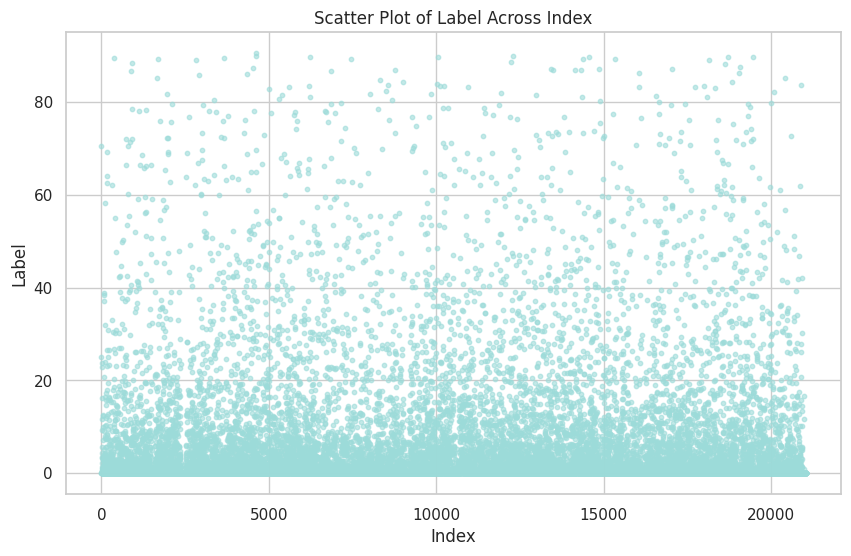

2024-10-03 15:07:22 | INFO | [/home/nicolawong/gene_expression_prediction/methylation_analysis/predict_gene.py:204] minimum non-zero value: 0.004894, using 4.894e-05 as a constant for log transform [plotting only]


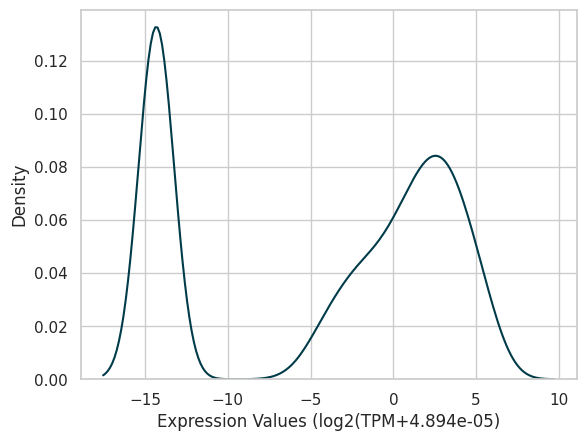

2024-10-03 15:07:22 | INFO | [/home/nicolawong/gene_expression_prediction/methylation_analysis/predict_gene.py:1252] Training with 71 features...
2024-10-03 15:07:22 | INFO | [/home/nicolawong/gene_expression_prediction/methylation_analysis/predict_gene.py:591] ['strand', 'mean_modc_before_tss_sense', 'mean_modc_after_tes_sense', 'mean_modc_genes_sense', 'mean_modc_first_exons_sense', 'mean_modc_first_introns_sense', 'mean_modc_before_tss_antisense', 'mean_modc_after_tes_antisense', 'mean_modc_genes_antisense', 'mean_modc_first_exons_antisense', 'mean_modc_first_introns_antisense', 'mean_modc_exons_sense', 'mean_modc_introns_sense', 'mean_modc_five_prime_utrs_sense', 'mean_modc_three_prime_utrs_sense', 'mean_modc_exons_antisense', 'mean_modc_introns_antisense', 'mean_modc_five_prime_utrs_antisense', 'mean_modc_three_prime_utrs_antisense', 'cpg_count_before_tss_sense', 'cpg_count_after_tes_sense', 'cpg_count_genes_sense', 'cpg_count_first_exons_sense', 'cpg_count_first_introns_sense', '

Columns with nan values:Index([], dtype='object')


2024-10-03 15:07:33 | WARNING | [/home/nicolawong/gene_expression_prediction/methylation_analysis/predict_gene.py:344] Cluster 1 in testing set has all NaNs for column cpg_count_genes_sense.
2024-10-03 15:07:33 | WARNING | [/home/nicolawong/gene_expression_prediction/methylation_analysis/predict_gene.py:344] Cluster 1 in testing set has all NaNs for column cpg_count_first_introns_sense.
2024-10-03 15:07:37 | WARNING | [/home/nicolawong/gene_expression_prediction/methylation_analysis/predict_gene.py:344] Cluster 1 in testing set has all NaNs for column range_length_first_introns_sense.
2024-10-03 15:07:39 | INFO | [/home/nicolawong/gene_expression_prediction/methylation_analysis/predict_gene.py:610] Shape of train data
2024-10-03 15:07:39 | INFO | [/home/nicolawong/gene_expression_prediction/methylation_analysis/predict_gene.py:612] Shape of test data
2024-10-03 15:07:39 | INFO | [/home/nicolawong/gene_expression_prediction/methylation_analysis/predict_gene.py:572] minimum non-zero valu

training with {'colsample_bytree': 0.7, 'eta': 0.02, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.7}


2024-10-03 15:08:07 | INFO | [/home/nicolawong/gene_expression_prediction/methylation_analysis/predict_gene.py:1160] Regressor performance:          mse      rmse       mae        r2  spearman
0  24.974758  4.997475  4.092259  0.538572  0.756045


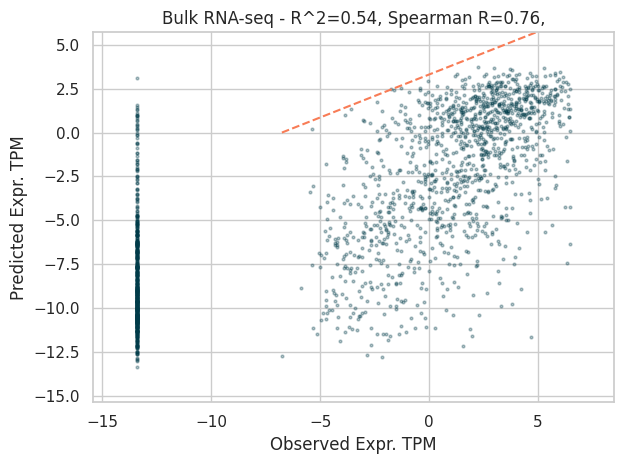

2024-10-03 15:08:07 | INFO | [/home/nicolawong/gene_expression_prediction/methylation_analysis/predict_gene.py:1339] ========================================================================================================================================================================================================
2024-10-03 15:08:07 | INFO | [/home/nicolawong/gene_expression_prediction/methylation_analysis/predict_gene.py:591] ['strand', 'mean_modc_before_tss_sense', 'mean_modc_after_tes_sense', 'mean_modc_genes_sense', 'mean_modc_first_exons_sense', 'mean_modc_first_introns_sense', 'mean_modc_before_tss_antisense', 'mean_modc_after_tes_antisense', 'mean_modc_genes_antisense', 'mean_modc_first_exons_antisense', 'mean_modc_first_introns_antisense', 'mean_modc_exons_sense', 'mean_modc_introns_sense', 'mean_modc_five_prime_utrs_sense', 'mean_modc_three_prime_utrs_sense', 'mean_modc_exons_antisense', 'mean_modc_introns_antisense', 'mean_modc_five_prime_utrs_antisense', 'mean_modc_three_

training 2 category model with {'colsample_bytree': 0.7, 'eta': 0.02, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.7}


2024-10-03 15:09:06 | INFO | [/home/nicolawong/gene_expression_prediction/methylation_analysis/predict_gene.py:1404] for 2 categories, test eval metrics:    number_of_categories  accuracy  macro_f1       auc
0                     2  0.839714   0.83132  0.907339
2024-10-03 15:09:06 | INFO | [/home/nicolawong/gene_expression_prediction/methylation_analysis/predict_gene.py:591] ['strand', 'mean_modc_before_tss_sense', 'mean_modc_after_tes_sense', 'mean_modc_genes_sense', 'mean_modc_first_exons_sense', 'mean_modc_first_introns_sense', 'mean_modc_before_tss_antisense', 'mean_modc_after_tes_antisense', 'mean_modc_genes_antisense', 'mean_modc_first_exons_antisense', 'mean_modc_first_introns_antisense', 'mean_modc_exons_sense', 'mean_modc_introns_sense', 'mean_modc_five_prime_utrs_sense', 'mean_modc_three_prime_utrs_sense', 'mean_modc_exons_antisense', 'mean_modc_introns_antisense', 'mean_modc_five_prime_utrs_antisense', 'mean_modc_three_prime_utrs_antisense', 'cpg_count_before_tss_sense', 'cp

training 3 category model with {'colsample_bytree': 0.7, 'eta': 0.02, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.7}


2024-10-03 15:10:28 | INFO | [/home/nicolawong/gene_expression_prediction/methylation_analysis/predict_gene.py:1404] for 3 categories, test eval metrics:    number_of_categories  accuracy  macro_f1      auc
0                     3  0.726901  0.677261  0.84851
2024-10-03 15:10:28 | INFO | [/home/nicolawong/gene_expression_prediction/methylation_analysis/predict_gene.py:591] ['strand', 'mean_modc_before_tss_sense', 'mean_modc_after_tes_sense', 'mean_modc_genes_sense', 'mean_modc_first_exons_sense', 'mean_modc_first_introns_sense', 'mean_modc_before_tss_antisense', 'mean_modc_after_tes_antisense', 'mean_modc_genes_antisense', 'mean_modc_first_exons_antisense', 'mean_modc_first_introns_antisense', 'mean_modc_exons_sense', 'mean_modc_introns_sense', 'mean_modc_five_prime_utrs_sense', 'mean_modc_three_prime_utrs_sense', 'mean_modc_exons_antisense', 'mean_modc_introns_antisense', 'mean_modc_five_prime_utrs_antisense', 'mean_modc_three_prime_utrs_antisense', 'cpg_count_before_tss_sense', 'cpg_

training 4 category model with {'colsample_bytree': 0.7, 'eta': 0.02, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.7}


2024-10-03 15:12:19 | INFO | [/home/nicolawong/gene_expression_prediction/methylation_analysis/predict_gene.py:1404] for 4 categories, test eval metrics:    number_of_categories  accuracy  macro_f1       auc
0                     4  0.661052  0.532631  0.827294
2024-10-03 15:12:19 | INFO | [/home/nicolawong/gene_expression_prediction/methylation_analysis/predict_gene.py:1411] classifier results: 
 {classifier_res}
2024-10-03 15:12:19 | INFO | [/home/nicolawong/gene_expression_prediction/methylation_analysis/predict_gene.py:1412] ========================================================================================================================================================================================================
2024-10-03 15:12:19 | INFO | [/home/nicolawong/gene_expression_prediction/methylation_analysis/predict_gene.py:1418] Best performing classifier: 2 categories
2024-10-03 15:12:19 | INFO | [/home/nicolawong/gene_expression_prediction/methylation_analysis/predict_gen

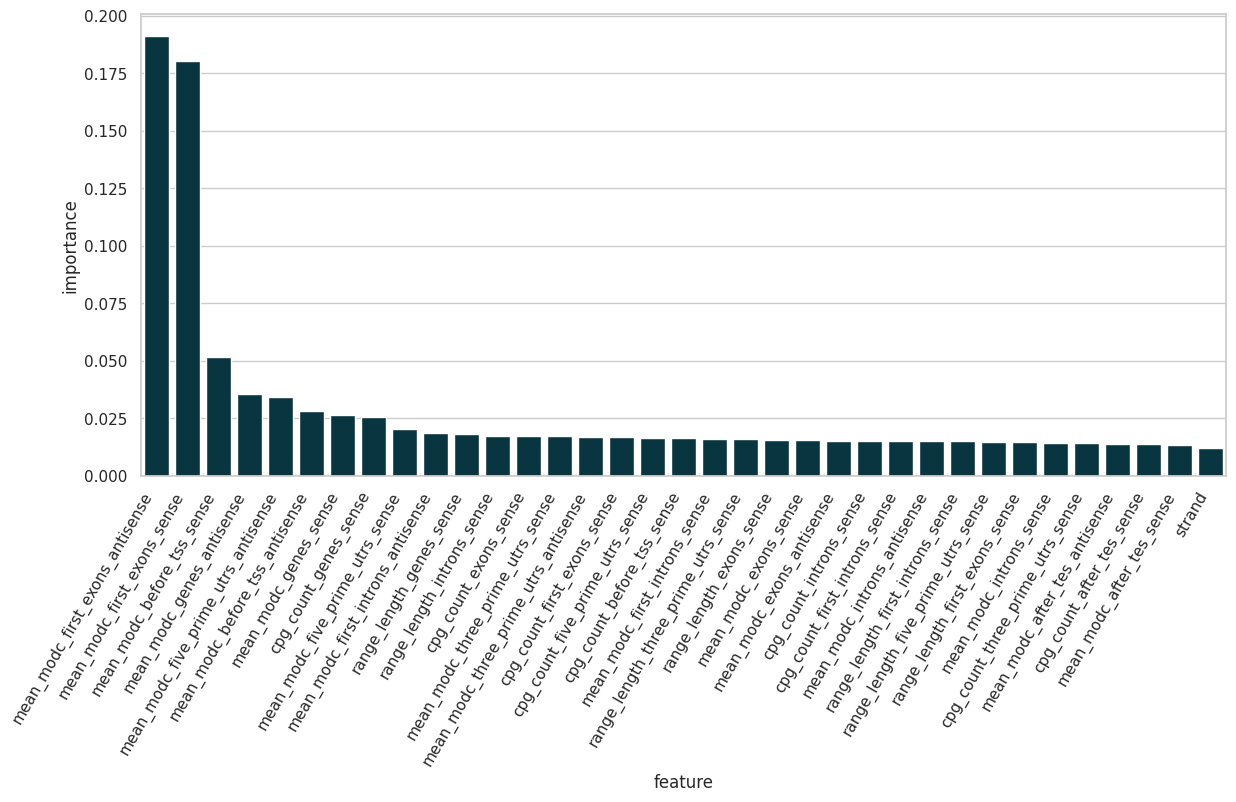

,number_of_categories,accuracy,macro_f1,auc
0,2,0.839714,0.831320,0.907339
1,3,0.726901,0.677261,0.848510
2,4,0.661052,0.532631,0.827294
